# Variational Prototyping Encoder for Interpretable Digit Classification: Code Structure and Explanation

This document outlines the code structure and theoretical underpinnings of a Variational Prototyping Encoder (VPE) designed for interpretable digit classification, with a focus on explainable AI (XAI). The project uses the MNIST dataset and explores the VPE's latent space to understand how it represents and distinguishes different digit classes.

## Table of Contents

1.  [Data Handling and Preprocessing](#data-handling)
2.  [Model Architecture: The Variational Prototyping Encoder](#model-architecture)
3.  [Loss Functions and Optimization](#loss-functions)
4.  [Explainable AI (XAI) Analysis: CAVs, Sensitivity, and Visualizations](#xai-analysis)
5.  [Training and Evaluation](#training-evaluation)

In [ ]:
import os
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image

from skimage.measure import label as skimage_label
from skimage.measure import regionprops
from skimage.morphology import opening, square
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sortedcontainers import SortedDict
from torch.autograd import grad
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

BINARY_INDEX = -1

cuda


## 1. Data Handling and Preprocessing <a name="data-handling"></a>

### **Data Augmentation and Prototype Loading: Enhancing Dataset Variability and Defining Class Representatives**

This code segment focuses on two important aspects of data preparation: data augmentation and prototype loading. Data augmentation artificially increases the size and variability of the training dataset, while prototype loading defines the representative examples for each digit class.

#### **Data Augmentation and its Benefits**

**Data Augmentation** is a technique used to artificially expand the training dataset by applying various transformations to the existing data. This helps to:

1.  **Improve Model Generalization:** By exposing the model to a wider range of variations in the data, it learns to be more robust and generalize better to unseen examples.
2.  **Reduce Overfitting:**  Augmentation acts as a regularizer, preventing the model from memorizing the training data and improving its ability to generalize.
3.  **Increase Data Diversity:**  It introduces more diversity into the training set, which can be particularly beneficial when the original dataset is limited in size or variability.

Common image augmentations include rotations, translations, scaling, shearing, flipping, and adding noise.

#### **Prototype Loading: Defining Class Representatives**

**Prototypes** serve as representative examples for each class. In this project, prototypes are pre-defined images that ideally capture the essential characteristics of each digit. Loading these prototypes is crucial for the VPE to learn a latent space that is structured around these exemplars.

#### **Implications for VPE Training and XAI**

*   **Data Augmentation:**
    *   Improves the VPE's ability to generalize to unseen variations in digit images.
    *   Makes the learned latent representations more robust to transformations like rotations and translations.
*   **Prototype Loading:**
    *   Provides the VPE with well-defined exemplars for each digit class.
    *   Ensures that the prototypes are preprocessed in a consistent manner with the MNIST data.
    *   Facilitates the analysis of prototype placement in the latent space.

#### **Augment Data and Load Prototypes: Razionale**

*   **Data Augmentation:**
    *   To improve model generalization and robustness.
    *   To reduce overfitting to the specific characteristics of the training data.
    *   Addresses the limitations of a finite training dataset by artificially expanding it.
    *   Improves the model's ability to handle variations in digit appearance.
*   **Prototype Loading:**
    *   To define clear representatives for each digit class.
    *   To enable prototype-based analysis of the latent space.
    *   Provides a concrete definition of what constitutes a typical example of each digit class.
    *   Facilitates the analysis of how these prototypes are represented in the VPE's latent space. 

In [110]:
# Updated data augmentation with transforms
transform = transforms.Compose([
    transforms.RandomRotation(20),  # Random rotation between -20 to 20 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random shift, 0 shear
    transforms.ToTensor(),  # Convert image to tensor
])

# Data augmentation with transforms for prototype images
prototype_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
    transforms.Resize((28, 28)),                 # Match MNIST image size
    ToTensor(),                                  # Convert to tensor
    transforms.Lambda(lambda x: 1 - x)          # Invert the image
])

# Path to the prototype images
prototype_path = './prototypes/standardized_prototypes'

# Load and map the prototype images
prototypes = SortedDict()
label_map = {
    "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
    "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9
}

# Load the prototype images
for filename in os.listdir(prototype_path):
    label_name, ext = os.path.splitext(filename)
    if label_name in label_map and ext == '.png':
        image_path = os.path.join(prototype_path, filename)
        image = Image.open(image_path)
        prototypes[label_map[label_name]] = prototype_transform(image)
        
# Verify prototype loading
print(f"Loaded prototypes: {list(prototypes.keys())}")

Loaded prototypes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### **Concept Extraction from MNIST Images: Defining Interpretable Features**

This section delves into the crucial process of extracting human-understandable concepts from MNIST digit images.  Instead of working directly with raw pixel data, which is difficult for humans to interpret, we define a set of *interpretable concepts* that capture essential characteristics of the digits. This forms the foundation for our XAI efforts on the VPE's latent space.

#### **The Importance of Interpretability**

In the context of XAI, interpretability is paramount.  We want to understand *why* a model makes a certain prediction, and to do so, we need to work with features that have meaning to us. Raw pixel intensities, while informative for a machine learning model, are not inherently meaningful to humans. By defining concepts that capture visual properties like shape, density, and symmetry, we bridge the gap between the model's internal representations and human understanding.

This idea aligns with the broader concept of **concept-based explanations** in XAI. The goal is to explain model behavior in terms of higher-level, human-understandable concepts rather than low-level features.

#### **Implications for VPE and Latent Space Analysis**

The VPE, as a generative model, learns to encode input data into a lower-dimensional latent space. This latent space ideally captures the essential factors of variation in the data.  By extracting these interpretable concepts *directly from the input images*, we create a ground truth that we can later compare against the VPE's latent representations.

This comparison allows us to investigate the following:

1.  **Latent Space Alignment:** To what extent does the VPE's latent space align with these human-defined concepts? Are there latent dimensions that correspond to circularity, pixel density, etc.?
2.  **Concept Encoding:** How does the VPE encode these concepts in its latent space?  Are they encoded linearly, non-linearly, or perhaps in a distributed manner?
3.  **Disentanglement:**  Does the VPE disentangle these concepts in its latent space? In a perfectly disentangled representation, each latent dimension would correspond to a single, independent factor of variation (e.g., one dimension for circularity, another for aspect ratio).

#### **Why These Specific Concepts?**

The five concepts chosen—circularity, pixel density, aspect ratio, symmetry, loopness—are motivated by their relevance to digit recognition and their intuitive interpretability:

1.  **Circularity:**  Captures the roundness of a digit. Useful for distinguishing digits like "0" and "8" from "1" or "7".
2.  **Pixel Density:**  Measures the proportion of active (foreground) pixels. Can help differentiate between digits with large filled areas (e.g., "8") and those with sparse strokes (e.g., "1").
3.  **Aspect Ratio:**  Reflects the height-to-width ratio of the digit. Useful for distinguishing tall digits like "1" and "7" from wider ones like "0" and "6".
4.  **Symmetry:**  Quantifies the horizontal and vertical symmetry of the digit. Some digits, like "0" and "8," exhibit higher symmetry than others, like "2" or "5."
5.  **Loopness:**  Determines if the digit has an hole in its representation. A digit like "6" and "8" present this characteristic rather than "1" or "3"

These concepts are also relatively straightforward to compute from images, making them practical choices for this analysis.

#### **Towards Explainable Latent Representations**

By defining and extracting these concepts, we address the following XAI challenges:

1.  **Lack of Interpretability in Latent Space:** The raw latent space of a VAE (or VPE) can be difficult to interpret. These concepts provide a human-understandable lens through which to analyze the latent space.
2.  **Difficulty in Evaluating Latent Space Structure:**  These concepts provide a benchmark for evaluating the quality of the VPE's latent space.  A "good" latent space should, to some extent, reflect these fundamental properties of the digits.
3.  **Limited Understanding of Model Decision-Making:** By understanding how these concepts are encoded in the latent space, we gain insights into how the VPE represents and processes different types of digits. This can shed light on the model's decision-making process when generating or reconstructing images.

In [111]:
def extract_concepts(images):
    """
    Extract interpretable concepts from MNIST images using skimage.measure.regionprops.

    Args:
        images (torch.Tensor): Batch of images (B, C, H, W) with pixel values in [0, 1].

    Returns:
        torch.Tensor: Concepts (B, num_concepts), where each row contains the concept values.
    """
    images_np = images.squeeze(1).cpu().numpy()  # Convert to (B, H, W)
    batch_concepts = []

    for img in images_np:
        # Ensure img is 2D (H, W)
        if img.ndim != 2:
            raise ValueError("Each image must be 2-dimensional.")

        # Binarize the image
        thresholded = (img > 0.3).astype(int)
        
        # Apply morphological opening to remove small noise
        opened = opening(thresholded, square(2))

        # Label connected regions
        labeled_img = skimage_label(opened)

        # Calculate region properties
        props = regionprops(labeled_img)

        if not props:  # Handle cases with no detected regions
            concepts = [0.0, 0.0, 0.0, 0.0, 0.0]  # or other default values
        else:
            # Assuming the largest region is the digit
            largest_region = max(props, key=lambda region: region.area)

            # 1. Circularity (using perimeter and area)
            perimeter = largest_region.perimeter
            area = largest_region.area
            circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6) if perimeter > 0 else 0.0
            circularity = min(circularity, 1.0)  # Clamp to 1

            # 2. Pixel Density
            pixel_density = area / img.size

            # 3. Aspect Ratio (using bounding box)
            min_row, min_col, max_row, max_col = largest_region.bbox
            height = max_row - min_row
            width = max_col - min_col
            aspect_ratio = height / (width + 1e-6)
            
            # 4. Orientation (angle of the major axis)
            orientation = largest_region.orientation
            
            # 5. Loopiness (using Euler number)
            has_loop = 1 if largest_region.euler_number < 1 else 0

            concepts = [circularity, pixel_density, aspect_ratio, orientation, has_loop]

        batch_concepts.append(concepts)

    # Convert to tensor and normalize
    concepts_tensor = torch.tensor(batch_concepts, dtype=torch.float32)
    return concepts_tensor

### **Extending MNIST for Prototypical Learning and Concept-Based Explanations**

This code snippet introduces a custom dataset class, `MNISTWithPrototypes`, which builds upon the standard `torchvision.datasets.MNIST` dataset. This extension is crucial for integrating prototypes and the previously defined concepts into the training and evaluation pipeline of our Variational Prototyping Encoder (VPE).

#### **Prototypical Learning and its Role in Explainability**

Prototypical learning is a paradigm where each class (in this case, each digit 0-9) is represented by a set of *prototypes*. These prototypes are exemplars that capture the essential characteristics of the class.  In the context of VPEs, prototypes serve as learned, representative data points in the latent space.

The theoretical connection to explainability is that prototypes provide a **human-interpretable way to understand how the model classifies and represents different classes**. By examining the prototypes learned by the VPE, we can gain insights into what the model considers to be the defining features of each digit. This is especially valuable for understanding how these features are encoded in the latent space, leading to a more interpretable model.

#### **Implications for VPE Training and XAI**

By incorporating prototypes into the dataset, we enable the VPE to learn latent space representations that are anchored to these prototypes.  This has several implications:

1.  **Structured Latent Space:** The VPE's latent space is encouraged to be more structured, with regions corresponding to each prototype and, consequently, to each digit class.
2.  **Improved Generalization:** Prototypes can improve the model's ability to generalize to unseen data, as they provide a more robust representation of each class than individual data points.
3.  **Enhanced Interpretability:** As mentioned earlier, the prototypes themselves serve as interpretable landmarks in the latent space, facilitating the understanding of the model's internal representations.
4.  **Facilitating Concept-Prototype Comparisons:** Since each data point now also comes with associated ground-truth concept values (calculated in `extract_concepts`), we can directly compare how the VPE encodes these concepts with how it encodes information about class prototypes. This is key for exploring the connection between human-defined concepts and learned prototypes.

#### **Why a Custom Dataset?**

The standard MNIST dataset only provides images and labels. To incorporate prototypes and concepts, we need a way to:

1.  **Associate each image with its corresponding prototype:** This is achieved by looking up the prototype based on the image's label.
2.  **Calculate and provide the concept values for each image:** The `extract_concepts` function is called within `__getitem__` to dynamically generate these values.
3.  **Return these additional data points (prototypes, concepts) along with the image and label during training and evaluation.**

#### **Bridging the Gap Between Data, Prototypes, and Concepts**

This custom dataset addresses the following challenges:

1.  **Integrating Prototypes into the VPE Framework:** It seamlessly integrates prototypes into the training pipeline, making them readily available to the VPE model.
2.  **Connecting Data Points to Concepts:** It establishes a direct link between each data point and its corresponding concept values, enabling concept-based analysis of the latent space.
3.  **Unified Data Handling:** It provides a unified interface for accessing images, labels, prototypes, and concepts, simplifying the data handling process within the VPE training and evaluation loops.

In [112]:
class MNISTWithPrototypesSTATS(datasets.MNIST):
    '''
    MNIST dataset with prototypes, extending the original MNIST dataset.
    
    '''
    def __init__(self, *args, prototypes, **kwargs):
        super().__init__(*args, **kwargs)
        self.prototypes = prototypes

    def __getitem__(self, index):
        img, label = super().__getitem__(index)     # Get MNIST data
        prototype = self.prototypes[label]          # Get corresponding prototype
        concepts = extract_concepts(img)            # Generate concepts dynamically
        return img, label, prototype, concepts
    
    # Method to retrieve prototypes
    def get_prototypes(self):
        return self.prototypes

temp_dataset_with_prototypes = MNISTWithPrototypesSTATS(
    root='./data',
    train=True,
    download=True,
    transform=transform,
    prototypes=SortedDict({k: prototypes[k] for k in prototypes.islice(stop=7)}),   # Include prototypes 0-6
)

### **Dataset Splitting and DataLoader Creation: Preparing for In-Distribution and Out-of-Distribution Evaluation**

This code segment focuses on splitting the `MNISTWithPrototypes` dataset into training and testing sets and creating corresponding `DataLoader` objects. This setup is crucial for evaluating the Variational Prototyping Encoder (VPE) not only on data it has seen during training but also on *out-of-distribution* (OOD) data, which is a key aspect of our XAI investigation.

#### **In-Distribution vs. Out-of-Distribution Evaluation**

Traditional machine learning evaluation often focuses on performance on a test set drawn from the same distribution as the training set (in-distribution). However, to truly understand a model's generalization capabilities and the robustness of its learned representations, it's essential to also evaluate it on OOD data.

*   **In-distribution data** represents the typical data the model is expected to encounter during deployment.
*   **Out-of-distribution data** represents data that differs significantly from the training data, potentially belonging to new classes or exhibiting novel variations.

In our case, the in-distribution data consists of digits 0-6, while the out-of-distribution data consists of digits 7-9.

#### **Implications for VPE Evaluation and XAI**

Evaluating the VPE on both in-distribution and out-of-distribution data allows us to investigate several crucial aspects:

1.  **Generalization of Learned Representations:** How well do the VPE's learned representations (including its prototypes) generalize to unseen digit classes? Does the latent space structure learned from digits 0-6 provide a meaningful basis for representing digits 7-9?
2.  **Robustness of Latent Space Structure:** Is the latent space structure maintained when confronted with OOD data? Or does it become disorganized or distorted?
3.  **Concept Representation in OOD Scenarios:** How are the previously defined concepts represented for OOD digits? Are the relationships between concepts and latent dimensions consistent across in-distribution and out-of-distribution data? This is especially important when studying the disentanglement properties of the VPE.
4.  **Prototype Behavior with OOD Data:** How does the VPE handle OOD data in relation to its learned prototypes? Does it try to project OOD data onto existing prototypes (potentially leading to misclassification), or does it exhibit behavior that suggests it recognizes the novelty of the data? This has implications to the open set recognition problem.

#### **Why This Specific Split**

The choice to split the dataset based on digit classes (0-6 for training, 7-9 for testing) is motivated by the desire to perform a meaningful OOD evaluation. By holding out entire digit classes, we create a challenging scenario that tests the VPE's ability to generalize beyond the specific digits it has seen during training.

This split allows us to assess whether the VPE has learned fundamental principles of digit representation that can be applied to new, unseen digits or if it has simply memorized the specific characteristics of the training digits.

#### **Facilitating Rigorous Evaluation**

This data splitting and `DataLoader` creation strategy addresses the following:

1.  **Need for OOD Evaluation:** It provides the necessary data setup for evaluating the VPE's performance on both in-distribution and out-of-distribution data.
2.  **Efficient Data Loading:** The `DataLoader` objects efficiently load the data in batches during training and evaluation, handling shuffling and other data management tasks.
3.  **Reproducible Experiments:** By defining clear train/test splits and using `DataLoader`s, the experiments become more reproducible.

In [113]:
# Split the dataset into train (digits 0-6) and test (digits 7-9)
temp_train_indices = [i for i, t in enumerate(temp_dataset_with_prototypes.targets) if t.item() < 7]

# Create a validation set from the training data
temp_train_indices, _ = train_test_split(
    temp_train_indices,
    test_size=0.2,  # Use 20% of the training data for validation
    stratify=temp_dataset_with_prototypes.targets[temp_train_indices],  # Maintain class distribution
    random_state=2057231  # Set random seed for reproducibility
)

train_subset = Subset(temp_dataset_with_prototypes, temp_train_indices)
val_subset = Subset(temp_dataset_with_prototypes, _)

# Create DataLoaders
batch_size = 64
temp_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)    # No need to shuffle: statistics purpose
temp_val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)      # No need to shuffle: statistics purpose

print(f'Train set size: {len(train_subset)}')
for batch_idx, (images, labels, proto_images, concepts) in enumerate(temp_train_loader):
    print(f"Batch {batch_idx}: Concept shape {concepts.shape}")
    break

Train set size: 33548
Batch 0: Concept shape torch.Size([64, 1, 5])


In [6]:
# Compute mean and std on the training set
all_train_concepts = []
for images, labels, proto_images, concepts in tqdm(temp_train_loader, desc="Computing mean and std", total=len(temp_train_loader)):
    # Store only continuous concepts and squeeze out the extra dimension
    continuous_concepts = concepts[:, :, :-1].squeeze(1)  # Shape will be [64, 4]
    all_train_concepts.append(continuous_concepts)

all_train_concepts = torch.cat(all_train_concepts, dim=0)

MEAN = all_train_concepts.mean(dim=0)
STD = all_train_concepts.std(dim=0)

print(f"Mean of concepts (training set): {MEAN}")
print(f"Std of concepts (training set): {STD}")

Computing mean and std: 100%|██████████| 525/525 [01:00<00:00,  8.65it/s]


Mean of concepts (training set): tensor([ 0.3132,  0.1398,  1.4480, -0.1723])
Std of concepts (training set): tensor([0.1325, 0.0561, 0.7789, 0.5904])


In [7]:
def standardize_concepts(concepts, mean, std):
    """Standardizes the continuous concept values.

    Args:
        concepts (torch.Tensor): Concepts (B, num_concepts).
        mean (torch.Tensor): Mean of continuous concepts from training set.
        std (torch.Tensor): Standard deviation of continuous concepts from training set.

    Returns:
        torch.Tensor: Standardized concepts (B, num_concepts).
    """
    continuous_concepts = concepts.squeeze(1)[:, :-1]  # Exclude the binary concept
    standardized_concepts = (continuous_concepts - mean) / std
    return torch.cat([standardized_concepts, concepts.squeeze(1)[:, -1:]], dim=1)  # Concatenate back the binary concept

class MNISTWithPrototypes(datasets.MNIST):
    """
    MNIST dataset with prototypes and concept standardization.
    """
    def __init__(self, *args, prototypes, **kwargs):
        super().__init__(*args, **kwargs)
        self.prototypes = prototypes
        self.mean = MEAN
        self.std = STD

    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        prototype = self.prototypes[label]
        concepts = extract_concepts(img)
        concepts = standardize_concepts(concepts, self.mean, self.std) # Standardize here
        return img, label, prototype, concepts
    
        # Method to retrieve prototypes
    def get_prototypes(self):
        return self.prototypes
    
train_dataset_with_prototypes = MNISTWithPrototypes(
    root='./data',
    train=True,
    download=True,
    transform=transform,
    prototypes=SortedDict({k: prototypes[k] for k in prototypes.islice(stop=7)}),   # Include prototypes 0-6
)

test_dataset_with_prototypes = MNISTWithPrototypes(
    root='./data',
    train=False,
    download=True,
    transform=transform,
    prototypes=SortedDict({k: prototypes[k] for k in prototypes.islice(7, 10)}),    # Include prototypes 7-9
)

In [8]:
# Split the dataset into train (digits 0-6) and test (digits 7-9)
train_indices = [i for i, t in enumerate(train_dataset_with_prototypes.targets) if t.item() < 7]
test_indices = [i for i, t in enumerate(test_dataset_with_prototypes.targets) if t.item() >= 7]

# Create a validation set from the training data
train_indices, val_indices = train_test_split(
    train_indices,
    test_size=0.2,  # Use 20% of the training data for validation
    stratify=train_dataset_with_prototypes.targets[train_indices],  # Maintain class distribution
    random_state=2057231  # Set random seed for reproducibility
)

train_subset = Subset(train_dataset_with_prototypes, train_indices)
val_subset = Subset(train_dataset_with_prototypes, val_indices)
test_subset = Subset(test_dataset_with_prototypes, test_indices)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)    # Shuffle training set
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)       # No need to shuffle validation set
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)     # No need to shuffle test set

print(f'Train set size: {len(train_subset)}, Validation set size: {len(val_subset)}, Test set size: {len(test_subset)}')
for batch_idx, (images, labels, proto_images, concepts) in enumerate(train_loader):
    print(f"Batch {batch_idx}: Images shape {images.shape}, Prototypes shape {proto_images.shape}, Concept shape {concepts.shape}")
    break

Train set size: 33548, Validation set size: 8387, Test set size: 3011
Batch 0: Images shape torch.Size([64, 1, 28, 28]), Prototypes shape torch.Size([64, 1, 28, 28]), Concept shape torch.Size([64, 1, 5])


### **Visualizing Input Images and Their Corresponding Prototypes**

This code snippet provides a simple yet effective way to visualize an input image from the training set and its associated prototype. This visualization is a valuable tool for understanding the relationship between data points and prototypes, which is a cornerstone of our exploration into the Variational Prototyping Encoder (VPE).

#### **The Role of Visualization in Understanding Model Behavior**

Visualization plays a crucial role in understanding and interpreting machine learning models, especially in the context of XAI. By visually inspecting the data and the model's internal representations, we can gain intuitive insights into how the model is processing information.

In the context of VPEs, visualizing input images alongside their corresponding prototypes helps us understand:

1.  **Prototype Representativeness:** How well does a prototype visually represent the typical characteristics of a digit class?
2.  **Prototype-Data Relationship:** How do individual data points relate to their assigned prototypes? Are they visually similar?
3.  **Potential Discrepancies:** Are there cases where an image seems visually dissimilar to its assigned prototype? This could indicate potential issues with prototype learning or assignment.

This visualization step, while seemingly simple, has several important implications for our analysis:

1.  **Sanity Check:** It serves as a sanity check to ensure that prototypes are being correctly associated with input images and that they visually resemble the digits they are supposed to represent.
2.  **Qualitative Assessment of Prototypes:** It allows for a qualitative assessment of the quality of the learned prototypes. Are they capturing the essential features of each digit class?
3.  **Debugging Tool:** If issues are observed (e.g., an image being assigned to a visually dissimilar prototype), this visualization can help pinpoint the source of the problem, whether it's in the prototype initialization, the VPE's training process, or the prototype assignment mechanism.
4.  **Building Intuition:** By visually inspecting numerous image-prototype pairs, we can build intuition about how the VPE is representing different digits and how prototypes are functioning within the model.

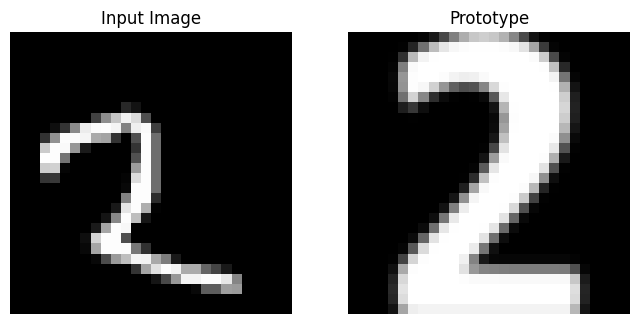

Label 2 | Concepts: tensor([-0.3565, -0.4461, -0.7036,  1.3079,  0.0000])


In [9]:
# Get a single batch of data from the train_loader
images, labels, prototypes, concepts = next(iter(train_loader))

# Select the first image and its corresponding prototype
index = 0
lbl = labels[index] 
img = images[index]
proto = prototypes[index]
concepts = concepts[index]

# Display the image
plt.figure(figsize=(8, 4))

# Plot the input image
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title("Input Image")
plt.axis('off')

# Plot the associated prototype
plt.subplot(1, 2, 2)
plt.imshow(proto.squeeze().numpy(), cmap='gray')
plt.title("Prototype")
plt.axis('off')

plt.show()

# plot the concepts
print(f"Label {lbl} | Concepts: {concepts[0]}")

### **Counting Classes and Visualizing Class Prototypes: Understanding the Dataset and Prototype Distribution**

This code segment focuses on determining the number of unique classes present in the training and testing datasets and then visualizes the prototype associated with each class. These steps are crucial for understanding the overall structure of the data and for gaining further insights into how prototypes are distributed across different digit classes within the Variational Prototyping Encoder (VPE) framework.

#### **Importance of Class Distribution and Prototype Visualization in XAI**

Understanding the distribution of classes within a dataset is fundamental to any machine learning task. In the context of XAI and VPEs, it's also important to understand how prototypes are distributed across these classes.

Visualizing the class prototypes provides a direct way to assess:

1.  **Prototype Diversity:** Are there distinct prototypes for each class, or do some classes share similar prototypes?
2.  **Prototype Coverage:** Do the prototypes adequately cover the range of variations within each class?
3.  **Potential Biases:** Are certain classes over-represented or under-represented in the prototype set?

These insights are essential for interpreting the VPE's behavior and for identifying potential areas for improvement.

#### **Implications for VPE Analysis and XAI**

The number of classes and the distribution of prototypes have several implications for our analysis:

1.  **Latent Space Structure:** The number of distinct prototypes can influence the structure of the VPE's latent space. We might expect to see clusters or regions corresponding to each prototype (and thus, each class).
2.  **Prototype-Based Classification:** The VPE's ability to classify images based on their proximity to prototypes depends on the distinctness and representativeness of the prototypes. Visualizing them helps assess their suitability for this task.
3.  **Understanding Model Decisions:** By examining the prototypes, we can gain insights into what the VPE considers to be the defining features of each class. This contributes to understanding the model's decision-making process.
4.  **Fairness and Bias Detection:** If certain classes have poorly defined or overlapping prototypes, it could lead to biases in the model's predictions. Visualizing the prototypes can help detect such issues.

#### **Count Classes and Visualize Prototypes: the implementation**

The motivations behind these steps are to:

1.  **Verify Dataset Integrity:** Ensure that the training and testing sets contain the expected number of classes and that prototypes are correctly assigned.
2.  **Assess Prototype Quality:** Gain a visual understanding of the quality and diversity of the learned prototypes.
3.  **Inform Subsequent Analyses:** The insights gained from this analysis will inform subsequent investigations into the VPE's latent space structure, prototype-concept relationships, and overall model behavior.

Moreover, hese steps contribute to:

1.  **Dataset Understanding:** Providing a clear picture of the class distribution and prototype assignments within the dataset.
2.  **Model Transparency:** Making the learned prototypes visually accessible, thereby enhancing the transparency of the VPE model.
3.  **Facilitating Further Analysis:** Laying the groundwork for more in-depth analyses of the VPE's internal representations and decision-making processes.

In [10]:
def count_classes(subset):
    """
    Efficiently counts the number of unique classes in a Subset.
    """
    return len(subset.dataset.targets[subset.indices].unique())

Number of classes in training set: 7
Number of classes in validation set: 7
Number of classes in test set: 3
Total number of classes: 10
Class target shape: torch.Size([10])
Class template shape: torch.Size([10, 1, 28, 28])


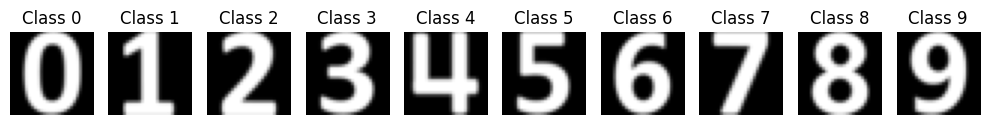

In [11]:
num_train_classes = count_classes(train_subset)
num_val_classes = count_classes(val_subset)
num_test_classes = count_classes(test_subset)

print(f"Number of classes in training set: {num_train_classes}")
print(f"Number of classes in validation set: {num_val_classes}")
print(f"Number of classes in test set: {num_test_classes}")

# For the purpose of ZSL, we usually consider only train and test
n_classes = num_train_classes + num_test_classes  # Total number of unique classes (seen + unseen)
print(f"Total number of classes: {n_classes}")

# Get prototypes for all classes (seen and unseen) - Assuming you want prototypes for all 10 classes
train_prototypes  = train_dataset_with_prototypes.get_prototypes()  # Access prototypes from the original dataset
test_prototypes = test_dataset_with_prototypes.get_prototypes()
prototypes = {**train_prototypes, **test_prototypes}
class_target = torch.LongTensor(list(range(n_classes))).to(device)
class_template = torch.stack([prototypes[i.item()] for i in class_target]).to(device)

print(f"Class target shape: {class_target.shape}")
print(f"Class template shape: {class_template.shape}")

# Visualize class prototypes
plt.figure(figsize=(10, 2))  # Adjust figure size as needed
for i in range(n_classes):
    plt.subplot(1, n_classes, i + 1)
    plt.imshow(class_template[i].mean(dim=0).cpu().numpy(), cmap='gray') # mean of the prototype images
    plt.title(f"Class {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 2. Model Architecture: The Variational Prototyping Encoder <a name="model-architecture"></a>

### **The VAEIdsia Architecture: A Standard Variational Autoencoder with a Concept Bottleneck**

This code defines a standard Variational Autoencoder (VAE) architecture called `VAEIdsia`, but with an added "concept bottleneck" layer designed for interpretability. Let's break down the theoretical underpinnings and implications of this architecture in the context of our XAI goals.

#### **Theory: Variational Autoencoders (VAEs) and the Evidence Lower Bound (ELBO)**

VAEs are a type of generative model that learns a probabilistic mapping between the input data space and a latent space. They are trained to maximize the Evidence Lower Bound (ELBO), which is a lower bound on the log-likelihood of the data. The ELBO consists of two terms:

1.  **Reconstruction Loss:** Measures how well the VAE can reconstruct the input data from its latent representation. This encourages the VAE to learn a latent space that captures the essential information in the data.
2.  **KL Divergence:** Measures the difference between the distribution of the latent variables and a prior distribution (usually a standard normal distribution). This encourages the latent space to be well-behaved and prevents it from overfitting to the training data.

The key idea behind VAEs is that by learning a probabilistic encoder and decoder, they can generate new data samples by sampling from the latent space and then decoding the sampled points.

#### **Implications of the VAEIdsia Architecture**

The `VAEIdsia` architecture has the following key features:

1.  **Convolutional Encoder and Decoder:** The use of convolutional layers in both the encoder and decoder allows the VAE to effectively process image data, capturing spatial hierarchies and patterns.
2.  **Latent Space:** The `latent_variable_size` parameter determines the dimensionality of the latent space. This is a crucial hyperparameter that affects the model's capacity to represent information and its ability to generalize.
3.  **Reparameterization Trick:** The `reparametrize` method implements the reparameterization trick, which is essential for training VAEs using backpropagation. It allows gradients to flow through the sampling process by expressing the latent variable as a deterministic function of the mean, standard deviation, and a noise variable.
4.  **Concept Bottleneck:** The `concept_bottleneck_layer` is the most significant addition for our XAI purposes. It takes the sampled latent vector `z` and projects it down to a low-dimensional vector representing "concepts." The sigmoid activation ensures that these concept values are between 0 and 1, potentially representing the presence or absence (or degree) of a particular concept.

#### **Why a Concept Bottleneck?**

The concept bottleneck is motivated by the desire to:

1.  **Introduce Interpretability:** By forcing the VAE to represent information in terms of a small number of concepts, we aim to make the latent space more interpretable. Each dimension of the concept bottleneck output can potentially be associated with a human-understandable concept.
2.  **Promote Disentanglement:** Ideally, each concept dimension would correspond to a single, independent factor of variation in the data. This would mean that changing one concept value while keeping others fixed would result in a change in a specific, interpretable aspect of the generated image (e.g., changing the "circularity" concept would make the generated digit more or less circular).
3.  **Enable Concept-Based Control:** By manipulating the concept bottleneck output, we could potentially control the attributes of generated images in a meaningful way.

#### **Solutions Addressed: Towards Interpretable Latent Representations**

The concept bottleneck addresses the following challenges:

1.  **Opacity of Standard VAE Latent Spaces:** The latent spaces of standard VAEs can be difficult to interpret. The concept bottleneck provides a more interpretable representation.
2.  **Lack of Control Over Generation:** By manipulating the concept bottleneck, we might be able to gain more control over the image generation process.
3.  **Limited Understanding of Learned Features:** The concept bottleneck can help us understand what features the VAE has learned to represent in its latent space.

**Limitations and Considerations:**

*   The effectiveness of the concept bottleneck depends heavily on the choice of the number of concepts (`concept_dim`) and the training process. It's not guaranteed that the learned concepts will align with human-understandable concepts or be perfectly disentangled.
*   There's a trade-off between interpretability and reconstruction quality. Forcing the VAE to represent information through a narrow bottleneck might harm its ability to reconstruct complex images accurately.

In [12]:
class VAEIdsia(nn.Module):
    def __init__(self, nc=1, input_size=28, latent_variable_size=64, cnn_chn=[32, 64, 128], concept_dim=5, binary_concepts=1, continuous_concepts=4):
        super(VAEIdsia, self).__init__()
        
        self.input_size = input_size    # size of input images
        self.nc = nc    # number of channels
        self.latent_variable_size = latent_variable_size    # size of latent variable
        self.cnn_chn = cnn_chn  # number of channels in CNN layers
        self.concept_dim = concept_dim  # number of concepts
        self.binary_concepts = binary_concepts    # number of binary concepts
        self.continuous_concepts = continuous_concepts    # number of continuous concepts

        # Encoder
        self.e1 = nn.Conv2d(nc, cnn_chn[0], 3, 2, 1)  # 28x28 -> 14x14, 
        self.bn1 = nn.BatchNorm2d(cnn_chn[0])
        self.e2 = nn.Conv2d(cnn_chn[0], cnn_chn[1], 3, 2, 1)  # 14x14 -> 7x7
        self.bn2 = nn.BatchNorm2d(cnn_chn[1])
        self.e3 = nn.Conv2d(cnn_chn[1], cnn_chn[2], 3, 1, 1)  # 7x7 -> 7x7
        self.bn3 = nn.BatchNorm2d(cnn_chn[2])

        self.fc1 = nn.Linear(cnn_chn[2] * 7 * 7, latent_variable_size)
        self.fc2 = nn.Linear(cnn_chn[2] * 7 * 7, latent_variable_size)

        # Concept Bottleneck [XAI]
        self.Xfc1 = nn.Linear(latent_variable_size, 64)             # Linear layer for concept bottleneck
        self.Xfc2_binary = nn.Linear(64, binary_concepts)           # Output head for binary concepts
        self.Xfc2_continuous = nn.Linear(64, continuous_concepts)   # Output head for continuous concepts

        # Decoder
        self.d1 = nn.Linear(latent_variable_size, cnn_chn[2] * 7 * 7)
        self.up1 = nn.ConvTranspose2d(cnn_chn[2], cnn_chn[1], 4, 2, 1)  # 7x7 -> 14x14
        self.bn6 = nn.BatchNorm2d(cnn_chn[1])
        self.up2 = nn.ConvTranspose2d(cnn_chn[1], cnn_chn[0], 4, 2, 1)  # 14x14 -> 28x28
        self.bn7 = nn.BatchNorm2d(cnn_chn[0])
        self.up3 = nn.Conv2d(cnn_chn[0], nc, 3, 1, 1)  # 28x28 -> 28x28
        
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.leakyrelu(self.bn1(self.e1(x)))
        h2 = self.leakyrelu(self.bn2(self.e2(h1)))
        h3 = self.leakyrelu(self.bn3(self.e3(h2)))
        h3 = h3.view(h3.size(0), -1)  # Flatten
        return self.fc1(h3), self.fc2(h3)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def concept_bottleneck_layer(self, z):
        h1 = self.relu(self.Xfc1(z))
        # Binary Concepts Head
        h_binary = self.sigmoid(self.Xfc2_binary(h1))
        # Continuous Concepts Head
        h_continuous = self.Xfc2_continuous(h1)  # No activation function for continuous concepts
        # Concatenate the outputs
        h2 = torch.cat((h_continuous, h_binary), dim=1)
        return h2.view(h2.size(0), 1, -1)  # shape: (B, 1, num_concepts) --> (64, 1, 4)   

    def decode(self, z):
        h1 = self.relu(self.d1(z))
        h1 = h1.view(-1, self.cnn_chn[2], 7, 7)
        h2 = self.leakyrelu(self.bn6(self.up1(h1)))
        h3 = self.leakyrelu(self.bn7(self.up2(h2)))
        return self.sigmoid(self.up3(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        reconstruction = self.decode(z)
        concepts = self.concept_bottleneck_layer(z)
        return reconstruction, mu, logvar, concepts

## 3. Loss Functions and Optimization <a name="loss-functions"></a>

### **Loss Functions: Guiding the VPE Towards Meaningful Representations**

This code defines several loss functions that are used to train the Variational Prototyping Encoder (VPE). These loss functions are crucial for shaping the VPE's latent space and ensuring that it learns representations that are both accurate (in terms of reconstruction) and interpretable (in terms of alignment with human-defined concepts and prototypes).

#### **Theory: Loss Functions and Their Role in Optimization**

Loss functions are the cornerstone of training any AI model. They quantify the difference between the model's predictions and the ground truth, providing a signal that guides the optimization process (typically via gradient descent). By minimizing the loss function, the model learns to make better predictions.

In the context of VAEs, the loss function typically combines a reconstruction loss (measuring how well the input is reconstructed) and a regularization term (encouraging the latent space to have desirable properties).

#### **Loss Functions Defined**

1.  **`BCE_KLD_loss(recon_x, proto, mu, logvar)`:** This is the standard loss function for VAEs, combining:
    *   **Binary Cross-Entropy (BCE):** Measures the reconstruction error between the reconstructed output (`recon_x`) and the target (`proto`). Clamping the inputs to `[0, 1]` ensures valid probability values for the BCE loss.
    *   **Kullback-Leibler Divergence (KLD):**  Measures the divergence between the learned latent distribution (parameterized by `mu` and `logvar`) and a standard normal prior. This term encourages the latent space to be well-behaved and prevents overfitting.

2.  **`perceptual_loss(recon_x, proto)`:** This function computes the Mean Squared Error (MSE) between the reconstructed output and the target. While similar to BCE, MSE can be more sensitive to pixel-wise differences, potentially leading to sharper reconstructions.

3.  **`concept_loss(predicted_concepts, ground_truth_concepts)`:** This loss function is specifically designed for our XAI goals. It measures the MSE between the concepts predicted by the VPE's concept bottleneck (`predicted_concepts`) and the ground-truth concepts extracted from the input images (`ground_truth_concepts`).  Minimizing this loss encourages the VPE to encode the pre-defined concepts accurately in its latent space.

4.  **`CenterLoss` class:** This class implements the Center Loss, which aims to improve the discriminative power of the learned features (in our case, the latent space of the VPE) by minimizing the intra-class variance. It achieves this by learning a "center" for each class in the latent space and pulling the latent representations of samples belonging to the same class closer to their respective centers. The center loss helps to form compact clusters in the latent space for each digit.

#### **`epsilon_greedy_loss` Function: Dynamically Choosing the Loss**

The `epsilon_greedy_loss` function introduces a novel approach to training by dynamically choosing between different loss functions based on an epsilon-greedy strategy. This strategy balances exploration (trying out different losses) and exploitation (using the standard VAE loss).

*   **Exploration (with probability `epsilon`):** Randomly selects one of the alternative loss functions: `perceptual_loss`, `concept_loss`, or a combination of reconstruction loss and `CenterLoss`. This encourages the VPE to explore different aspects of the data and potentially discover more meaningful representations.
*   **Exploitation (with probability `1 - epsilon`):** Uses the standard `BCE_KLD_loss`. This ensures that the VPE doesn't deviate too far from the standard VAE training objective.

The counters keep track of how often each branch (exploration or exploitation) is chosen, providing insights into the training dynamics.

#### **Implications for VPE Training and XAI**

These loss functions and the epsilon-greedy strategy have several important implications:

1.  **Shaping the Latent Space:** The combination of losses guides the VPE to learn a latent space that is not only good for reconstruction but also aligned with human-defined concepts and structured according to class prototypes.
2.  **Concept Learning:** The `concept_loss` directly encourages the VPE to encode the pre-defined concepts accurately.
3.  **Discriminative Features:** The `CenterLoss` promotes the formation of well-separated clusters in the latent space, making it easier to distinguish between different digit classes.
4.  **Exploration and Exploitation:** The epsilon-greedy strategy allows the VPE to balance the exploration of different loss functions with the exploitation of the standard VAE objective, potentially leading to better overall performance and more interpretable representations.

#### **Why These Specific Losses?**

The choice of these loss functions is motivated by the desire to:

1.  **Learn a Meaningful Latent Space:**  A latent space that is not only good for reconstruction but also reflects human-understandable concepts and the structure of the data (in terms of digit classes).
2.  **Promote Interpretability:** By encouraging the VPE to encode concepts and form distinct clusters, these losses enhance the interpretability of the latent space.
3.  **Improve Generalization:** The Center Loss can potentially improve generalization by making the latent representations more robust to intra-class variations.

#### **Towards Interpretable and Structured Latent Representations**

These loss functions address the following XAI challenges:

1.  **Uninterpretable Latent Spaces:** By incorporating concept and center losses, the VPE is guided towards learning more interpretable and structured latent representations.
2.  **Lack of Control Over Latent Space Organization:** The Center Loss provides a mechanism for controlling the organization of the latent space, encouraging the formation of distinct clusters for each class.
3.  **Difficulty in Connecting Latent Representations to Concepts:** The concept loss directly connects the VPE's latent representations to human-defined concepts.

In [13]:
def BCE_KLD_loss(recon_x, proto, mu, logvar):
    recon_x = torch.clamp(recon_x, 0, 1)  # Ensure reconstruction is valid
    proto = torch.clamp(proto, 0, 1)      # Ensure prototype is valid
    BCE = F.binary_cross_entropy(recon_x, proto, reduction='sum')   # Reconstruction loss  
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   # KL divergence
    return BCE + KLD

def perceptual_loss(recon_x, proto):
    return F.mse_loss(recon_x, proto, reduction='sum')

def concept_loss(predicted_concepts, ground_truth_concepts, binary_index=BINARY_INDEX, device='cuda'):
    """
    Computes the concept prediction loss using BCE for the binary concept and MSE for continuous concepts.
    Args:
        predicted_concepts: Concepts predicted by the bottleneck layer (batch_size, concept_dim).
        ground_truth_concepts: Extracted ground-truth concepts (batch_size, concept_dim or batch_size, 1, concept_dim).
        binary_index: Index of the binary concept in the concept array.
        device: The device to ensure tensors are on.
    Returns:
        Loss value (float).
    """

    # Move tensors to the same device
    predicted_concepts = predicted_concepts.squeeze(1).to(device)           # From [64, 1, 5] to [64, 5]
    ground_truth_concepts = ground_truth_concepts.squeeze(1).to(device)     # From [64, 1, 5] to [64, 5]

    # Extract binary and continuous concepts
    pred_binary = predicted_concepts[:, binary_index]       # Binary concept (B,)   ----> [64,]
    true_binary = ground_truth_concepts[:, binary_index]    # Binary concept (B,)   ----> [64,]

    # Continuous concepts exclude the binary index
    pred_continuous = predicted_concepts[:, :binary_index]  # Continuous concepts [64, 4]
    true_continuous = ground_truth_concepts[:, :binary_index]   # Continuous concepts [64, 4]

    # Compute binary loss (BCE)
    binary_loss = F.binary_cross_entropy(pred_binary, true_binary, reduction='sum')

    # Compute continuous loss (MSE)
    continuous_loss = F.mse_loss(pred_continuous, true_continuous, reduction='sum')

    # Combine losses
    return binary_loss + continuous_loss
    
class CenterLoss(nn.Module):
    """Center loss for VPE latent space."""
    def __init__(self, n_classes, model, device='cuda'):
        super(CenterLoss, self).__init__()
        self.num_classes = n_classes
        self.feat_dim = model.latent_variable_size

        # Initialize class centers
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim)).to(device)

    def forward(self, features, labels):
        """
        Args:
            features: Latent features from the VPE model (batch_size, feat_dim).
            labels: Ground truth labels (batch_size).
            
        Reference:
            https://github.com/OrkhanHI/Center-Loss-A-Discriminative-Feature-Learning-Approach-for-Deep-Face-Recognition-/blob/master/Center_Loss_Train.ipynb
        """
        batch_size = features.size(0)

        # Compute pairwise distances
        distmat = (
            torch.pow(features, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes)
            + torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        )
        distmat.addmm_(features, self.centers.t(), beta=1, alpha=-2)  # Add feature-center distances

        # Mask for ground truth centers
        classes = torch.arange(self.num_classes).long().to(device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes).to(device)
        mask = labels.eq(classes.expand(batch_size, self.num_classes)).to(device)

        # Compute loss only for matching centers
        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss
    
# Epsilon-greedy logic for loss selection

def epsilon_greedy_loss(recon_x, proto, mu, logvar, labels, epsilon, center_loss_fn, lambda_center, counters,
                        predicted_concepts=None, ground_truth_concepts=None, lambda_concept=1.0, binary_index=BINARY_INDEX):
    """
    Choose the loss function based on epsilon-greedy strategy.
    Args:
        recon_x, proto, mu, logvar: Inputs for BCE+KLD loss.
        features, labels: Inputs for center loss.
        epsilon: Exploration probability.
        center_loss_fn: Instance of CenterLoss.
        lambda_center: Weight for center loss.
        predicted_concepts: Predicted concepts from the bottleneck layer.
        ground_truth_concepts: Ground truth concepts.
        lambda_concept: Weight for concept loss.
        counters: Dictionary to keep track of exploration/exploitation counts.
        binary_index: Index of the binary concept in the concept array.
    Returns:
        Computed loss.
    """
    if random.random() < epsilon:   # random.random() returns a random float in [0.0, 1.0)
        counters['explore'] += 1
        # Exploration: randomly pick one of the alternative losses
        choice = random.choice(["perceptual", "center"])
        if choice == "perceptual":
            return perceptual_loss(recon_x, proto)
        elif choice == "center":
            reconstruction_loss = F.mse_loss(recon_x, proto)
            loss = reconstruction_loss + (lambda_center * center_loss_fn(mu, labels))
            return loss
    else:
        # Exploitation: use the standard BCE+KLD loss with concept loss
        counters['exploit'] += 1
        
        if predicted_concepts is not None and ground_truth_concepts is not None:
            additional_loss = lambda_concept * concept_loss(predicted_concepts, ground_truth_concepts, binary_index)
        else:
            raise ValueError("Missing predicted_concepts or ground_truth_concepts for concept loss.")
        
        return BCE_KLD_loss(recon_x, proto, mu, logvar) + additional_loss

## 4. Explainable AI (XAI) Analysis: CAVs and Sensitivity <a name="xai-analysis"></a>

### **Concept Activation Vectors (CAVs) and Sensitivity Analysis: Quantifying Concept Influence in the Latent Space**

This code defines two crucial functions for our XAI analysis: `compute_cavs` and `compute_sensitivity`. These functions allow us to quantify the influence of human-defined concepts on the VPE's latent space, providing a way to measure how well the latent dimensions align with these concepts.

#### **Concept Activation Vectors (CAVs) and Their Role in Interpretability**

Concept Activation Vectors (CAVs) are a powerful tool for understanding how concepts are represented within a neural network's internal representations. A CAV represents the direction in the representation space (in our case, the VPE's latent space) that corresponds to a particular concept.

**Key Idea:** If a concept is encoded in the latent space, then moving along the CAV direction should correspond to a change in the degree to which that concept is present in the input.

For example, if we have a CAV for "circularity," then moving along that CAV in the latent space should make the generated image more or less circular.

**Computing CAVs:** CAVs are typically computed by training a linear classifier (in this code, a linear regressor using SGDRegressor) to distinguish between examples that have a concept and those that don't. The weight vector of this classifier then serves as the CAV.

#### **Sensitivity Analysis: Measuring the Impact of Concepts**

Sensitivity analysis, in this context, measures how sensitive the latent representations are to changes along each CAV. It quantifies the average magnitude of the directional derivative of the latent representations with respect to each CAV.

**Intuition:** A high sensitivity value for a given concept indicates that the latent representations are strongly influenced by that concept. Conversely, a low sensitivity value suggests that the concept has little impact on the latent representations.

#### **Implications for VPE Analysis and XAI**

The computation of CAVs and sensitivity analysis have several important implications for our analysis of the VPE:

1.  **Concept-Latent Space Alignment:** CAVs provide a quantitative measure of how well the VPE's latent space aligns with the pre-defined human-understandable concepts.
2.  **Identifying Important Concepts:** Sensitivity analysis helps identify which concepts are most strongly encoded in the latent space.
3.  **Understanding Latent Space Structure:** By examining the CAVs and their relationships to each other, we can gain insights into the structure of the latent space and how different concepts are encoded.
4.  **Evaluating Disentanglement:** If the concepts are well-disentangled in the latent space, we would expect the CAVs to be relatively orthogonal to each other, and each latent dimension to be primarily sensitive to only one concept.
5.  **Guiding Model Improvement:** The insights gained from CAV analysis can guide improvements to the VPE architecture or training process, leading to a more interpretable and controllable latent space.

#### **Why Compute CAVs and Sensitivity?**

The motivations behind computing CAVs and performing sensitivity analysis are to:

1.  **Quantify Concept Influence:** Move beyond qualitative assessments of interpretability and provide quantitative measures of how concepts are represented in the latent space.
2.  **Validate Concept Bottleneck:** Assess whether the concept bottleneck in the `VAEIdsia` architecture is effectively encoding the pre-defined concepts.
3.  **Gain Deeper Understanding of Latent Space:** Uncover the relationships between concepts and latent dimensions, providing a more nuanced understanding of the VPE's internal representations.

#### **Solutions Addressed: Bridging the Gap Between Latent Representations and Human Concepts**

These techniques address the following XAI challenges:

1.  **Opacity of Latent Spaces:** CAVs provide a way to "probe" the latent space and understand how it encodes human-interpretable concepts.
2.  **Difficulty in Evaluating Concept Encoding:** Sensitivity analysis provides a quantitative measure of how strongly each concept is encoded in the latent space.
3.  **Lack of Connection Between Model Internals and Human Understanding:** CAVs and sensitivity analysis bridge the gap between the VPE's internal representations and human-understandable concepts.

In [98]:
def compute_cavs(latent_representations, concept_labels):
    """
    Compute Concept Activation Vectors (CAVs) for continuous concepts.

    Args:
        latent_representations (torch.Tensor): Latent representations (N, latent_dim).
        concept_labels (torch.Tensor): Continuous concept labels (N, num_concepts).

    Returns:
        torch.Tensor: Concept Activation Vectors (num_concepts, latent_dim).
    """
    
    # Convert latent_representations to numpy array if it's a tensor
    if isinstance(latent_representations, torch.Tensor):
        latent_representations = latent_representations.cpu().detach().numpy()      # Shape: (N, latent_dim) --> (3011, 64)
    # Convert concept_labels to numpy array if it's a tensor
    if isinstance(concept_labels, torch.Tensor):
        concept_labels = concept_labels.squeeze(1).cpu().detach().numpy()       # Shape: (N, 1, num_concepts) --> (3011, 1, 5) SQEEZED TO (3011, 5)
    
    cavs = []        
    num_concepts = concept_labels.shape[1]  # Number of concepts (e.g., 5)
    bin_concept_idx = num_concepts - 1  # Index of the binary concept
    
    for concept_idx in range(num_concepts):
        # Extract labels for the current concept
        labels = concept_labels[:, concept_idx]  # Shape: (N,)
        
        # Check the concept index is not the final
        if concept_idx != bin_concept_idx: 
            latent_min = latent_representations.min(axis=0, keepdims=True) # Min for each dimension (1, latent_dim)
            latent_max = latent_representations.max(axis=0, keepdims=True) # Max for each dimension (1, latent_dim)
            normalized_latent_representations = (latent_representations - latent_min) / (latent_max - latent_min + 1e-6) # Add epsilon for stability
            # Train linear regression (SGD) to learn concept alignment
            reg = SGDRegressor(max_iter=1000, tol=1e-3)
            reg.fit(normalized_latent_representations, labels)
            # The weight vector of the regressor serves as the CAV
            cav = reg.coef_  # Shape: (latent_dim,)
        else:
            # Binary concept: use logistic regression
            clf = SGDClassifier(max_iter=1000, tol=1e-3)
            clf.fit(latent_representations, labels)
            cav = clf.coef_[0]
        
        cavs.append(cav)
    return cavs

# Sensitivity Analysis
def compute_sensitivity(latent_representations, cavs):
    """
    Compute sensitivity of latent representations to CAVs.

    Args:
        latent_representations (torch.Tensor): Latent space representations (N, latent_dim).
        cavs (list of numpy.ndarray): List of Concept Activation Vectors (CAVs), each of shape (latent_dim,).

    Returns:
        list: Sensitivity values for each concept.
    """
    sensitivities = []
    for cav in cavs:
        cav = torch.tensor(cav, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and align dimensions

        # Compute directional derivative
        directional_derivative = torch.matmul(latent_representations, cav.t()) 
        sensitivity = torch.abs(directional_derivative.mean(dim=0))  # Mean sensitivity
        sensitivities.append(sensitivity.item())

    return sensitivities

## 5. Training and Evaluation <a name="training-evaluation"></a>

In [15]:
try:
    del vae_model
    print('Delete existing model')
except:
    pass
torch.cuda.empty_cache()

### Code Explanation

This section initializes the key components for training a Variational Autoencoder (VAE) with also a center loss function. It also sets up parameters for exploration and exploitation during training.

In [16]:
# Initialize Variational Autoencoder (VAE) model and move to GPU
vae_model = VAEIdsia().cuda()

# Set up Adam optimizer with a learning rate of 0.001
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Configure Center Loss for feature-level clustering
center_loss_fn = CenterLoss(n_classes, vae_model, device=device)

# Hyperparameters for training
lambda_center = 0.01  # Weight for center loss regularization
epsilon = 0.1  # Exploration rate (10% chance of exploration)

# Initialize counters to track exploration vs exploitation strategy
counters = {
    'explore': 0,  # Number of exploration steps
    'exploit': 0   # Number of exploitation steps
}

### **The `train` Function: Orchestrating the VPE's Learning Process**

The `train` function is the heart of the VPE's training process. It iterates through the training data, computes the loss, and updates the model's parameters via backpropagation and optimization. Let's break down the key components and their theoretical underpinnings.

#### **Gradient-Based Optimization and Backpropagation**

Deep learning models are typically trained using gradient-based optimization algorithms, such as Stochastic Gradient Descent (SGD), Adam, or RMSprop. These algorithms iteratively adjust the model's parameters to minimize a given loss function.

**Backpropagation** is the core algorithm for computing the gradients of the loss function with respect to the model's parameters. It efficiently propagates error signals backward through the network, allowing us to determine how each parameter contributed to the overall loss.

**Optimization algorithms** then use these gradients to update the parameters, taking small steps in the direction that reduces the loss.

#### **Key Components of the `train` Function**

1.  **`model.train()`:** Sets the VPE model to training mode. This is important because some layers, like Batch Normalization and Dropout, behave differently during training and evaluation.

2.  **Iteration through `train_loader`:** The `train_loader` provides batches of training data (images, labels, prototypes, and concept labels). The code iterates through these batches, processing each one in turn.

3.  **`images, labels, prototypes = images.to(device), labels.to(device), prototypes.to(device)`:** Moves the data to the appropriate device (CPU or GPU) for computation.

4.  **`optimizer.zero_grad()`:** Resets the gradients of the model's parameters to zero before computing the gradients for the current batch. This is crucial because gradients accumulate across iterations by default in PyTorch.

5.  **`recon_batch, mu, logvar, concepts = model(images)`:** Performs a forward pass through the VPE model.
    *   The input `images` are passed through the encoder, generating the mean (`mu`) and log-variance (`logvar`) of the latent distribution.
    *   The `reparametrize` function (defined in the model) samples a latent vector `z` from this distribution.
    *   `z` is passed through the decoder to generate the reconstruction `recon_batch`.
    *   `z` is also passed through the concept bottleneck to produce `concepts`.

6.  **`loss = epsilon_greedy_loss(...)`:** Computes the loss using the `epsilon_greedy_loss` function, which dynamically chooses between different loss functions as explained in the previous section. It takes into consideration reconstructions, prototypes, latent variables, labels, exploration parameter epsilon, a center loss function, lambda center, counters for exploration/exploitation, predicted concepts and ground truth concepts.

7.  **`loss.backward()`:** Computes the gradients of the loss with respect to the model's parameters using backpropagation.

8.  **`train_loss += loss.item()`:** Accumulates the loss for the current epoch.

9.  **`optimizer.step()`:** Updates the model's parameters using the computed gradients and the chosen optimization algorithm.

10. **Exploration/Exploitation Ratio Calculation and Printing:** Calculates and prints the ratios of exploration and exploitation choices made by the `epsilon_greedy_loss` function during the epoch. This provides insights into the training dynamics.

#### **Implications for VPE Training and XAI**

This training process has several implications for our VPE and XAI goals:

1.  **Learning to Reconstruct and Encode Concepts:** The VPE learns to reconstruct input images while simultaneously encoding human-defined concepts into its latent space.
2.  **Shaping the Latent Space:** The combination of loss functions (reconstruction, KL divergence, concept loss, and potentially center loss) shapes the latent space, encouraging it to be both informative (for reconstruction) and interpretable (aligned with concepts and structured by class).
3.  **Dynamic Loss Landscape:** The epsilon-greedy strategy creates a dynamic loss landscape, potentially helping the VPE escape local optima and find better solutions.

#### **Motivations Behind This Training Procedure**

The specific choices made in this `train` function are motivated by the desire to:

1.  **Train an Effective VPE:** Learn a model that can accurately reconstruct input images and generate new ones.
2.  **Incorporate XAI Principles:**  Guide the VPE towards learning a latent space that is aligned with human-defined concepts.
3.  **Balance Different Objectives:** Use the epsilon-greedy strategy to balance the different objectives captured by the various loss functions.

#### **Training a VPE for Reconstruction, Concept Encoding, and Latent Space Structuring**

This training procedure addresses the following challenges:

1.  **Simultaneously Learning Reconstruction and Concept Encoding:** The combined loss function and the forward pass ensure that the VPE learns both to reconstruct images and to encode concepts.
2.  **Dynamically Balancing Multiple Objectives:** The epsilon-greedy strategy provides a way to dynamically balance the different objectives during training.
3.  **Creating a Structured and Interpretable Latent Space:** The loss functions (especially concept loss and center loss) guide the VPE towards learning a structured and interpretable latent space.

In [17]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for images, labels, prototypes, concept_labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        prototypes = prototypes.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, concepts = model(images)
        
        loss = epsilon_greedy_loss(recon_batch, prototypes, mu, logvar, labels, epsilon, center_loss_fn, lambda_center, counters, concepts, concept_labels)        
        loss.backward()
        train_loss += loss.item()
        
        optimizer.step()

        # Calculate exploration and exploitation percentages
    total_decisions = counters['explore'] + counters['exploit']
    exploration_ratio = (counters['explore'] / total_decisions) * 100 if total_decisions > 0 else 0
    exploitation_ratio = (counters['exploit'] / total_decisions) * 100 if total_decisions > 0 else 0
    print(f"Epoch {epoch}, Loss: {train_loss / len(train_subset):.4f}")
    print(f"Exploration/Exploitation: {exploration_ratio:.1f}%/{exploitation_ratio:.1f}%")
    return train_loss

In [18]:
def validate(model, data_loader):
    """
    Evaluates the model on the validation set.

    Args:
        model: The trained model.
        data_loader: DataLoader for the validation set.

    Returns:
        val_accuracy: Validation accuracy.
        val_loss: Average validation loss.
    """
    prototypes = data_loader.dataset.dataset.get_prototypes()

    # Extract unique classes from the validation data
    unique_classes = sorted(set(int(data_loader.dataset.dataset.targets[i]) for i in data_loader.dataset.indices))
    class_template = torch.stack([prototypes[c] for c in unique_classes]).to(device)
    n_classes = len(unique_classes)

    model.eval()
    val_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        _, class_mu, _, _ = model(class_template)
        for images, labels, prototypes, concept_labels in data_loader:
            images = images.to(device)
            labels = labels.to(device).squeeze()
            prototypes = prototypes.to(device)

            # Forward pass through the model
            recon_batch, mu, logvar, concepts = model(images)

            # Calculate the loss (make sure all loss functions and variables are defined)
            loss = epsilon_greedy_loss(recon_batch, prototypes, mu, logvar, labels, epsilon, center_loss_fn, lambda_center, counters, concepts, concept_labels)
            val_loss += loss.item()

            # Compute distance between the class prototypes and the latent representation
            sample_distance = torch.cdist(mu, class_mu, p=2)  # Efficient pairwise Euclidean distance
            predictions = torch.argmin(sample_distance, dim=1)

            all_predictions.append(predictions)
            all_labels.append(labels)

    # Combine predictions and labels for accuracy calculation
    all_predictions = torch.cat(all_predictions).cpu()
    all_labels = torch.cat(all_labels).cpu()
    val_accuracy = (all_predictions == all_labels).float().mean().item()

    # Normalize the validation loss by the number of samples
    val_loss /= len(data_loader.dataset)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return val_accuracy, val_loss

### **The `test` Function: Evaluating the VPE's Performance and Analyzing its Latent Space**

The `test` function evaluates the trained VPE model on the test set, focusing on classification accuracy, confusion matrix analysis, and most importantly, the computation of Concept Activation Vectors (CAVs) and sensitivity analysis to understand the latent space. Let's break down the code and discuss its theoretical implications.

#### **Model Evaluation, Confusion Matrices, CAVs, and Sensitivity Analysis**

*   **Model Evaluation:**  Evaluating a model on a held-out test set is crucial to assess its generalization ability – how well it performs on unseen data. Common metrics include accuracy, precision, recall, F1-score, and the confusion matrix.
*   **Confusion Matrix:**  A confusion matrix visualizes the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions for each class. It helps identify which classes the model is confusing and provides insights into the types of errors it's making.
*   **CAVs and Sensitivity (Recap):** As discussed previously, CAVs represent directions in the latent space corresponding to human-defined concepts, and sensitivity analysis quantifies the influence of each concept on the latent representations.

#### **Implications for VPE Analysis and XAI**

This `test` function is crucial for our XAI analysis because it:

1.  **Evaluates Generalization:** Assesses how well the VPE generalizes to unseen data (the test set).
2.  **Provides Insights into Model Errors:** The confusion matrix reveals which classes the VPE is struggling to distinguish, providing clues about potential weaknesses in the model or the learned prototypes.
3.  **Quantifies Concept Influence:** CAVs and sensitivity analysis provide quantitative measures of how well the pre-defined concepts are encoded in the latent space and how strongly they influence the latent representations.
4.  **Connects Latent Space to Concepts:**  This analysis helps bridge the gap between the abstract latent space and human-understandable concepts, making the VPE's internal representations more interpretable.
5.  **Informs Model Improvement:** The insights gained from the confusion matrix, CAVs, and sensitivity analysis can guide improvements to the VPE architecture, training process, or the choice of concepts, ultimately leading to a more accurate and interpretable model.

#### **Motivations of This Evaluation Procedure?**

The motivations behind this detailed evaluation are to:

1.  **Assess Model Performance:** Go beyond simple accuracy and gain a deeper understanding of the VPE's strengths and weaknesses.
2.  **Validate the Latent Space:** Evaluate whether the latent space is structured in a way that aligns with human-defined concepts.
3.  **Enhance Interpretability:** Make the VPE's internal representations more transparent and understandable.
4.  **Guide Model Refinement:** Use the evaluation results to improve the VPE's performance and interpretability.

#### **Evaluating Performance and Interpreting the Latent Space**

This `test` function addresses the following challenges:

1.  **Comprehensive Model Evaluation:**  Provides a comprehensive evaluation of the VPE's performance, including accuracy, per-class performance, and a detailed confusion matrix.
2.  **Quantifying Concept Encoding:** Uses CAVs and sensitivity analysis to quantify how well concepts are encoded in the latent space.
3.  **Interpreting Latent Representations:**  Connects the latent representations to human-understandable concepts, making the VPE more interpretable.

In [ ]:
def test(model, data_loader):
    # Access prototypes from the original dataset
    prototypes = data_loader.dataset.dataset.get_prototypes()
    
    # Determine unique classes in the current subset
    unique_classes = sorted(set(int(data_loader.dataset.dataset.targets[i]) for i in data_loader.dataset.indices))
    class_template = torch.stack([prototypes[c] for c in unique_classes]).to(device)
    n_classes = len(unique_classes)

    # Map original labels to sequential indices
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}

    model.eval()
    with torch.no_grad():
        # Get class reconstructions and latent representations
        _, class_mu, _, _ = model(class_template)
    
    # Initialize lists to store results
    all_predictions = []
    all_labels = []
    latent_representations = []
    concept_labels = []

    for images, labels, _, concepts in data_loader:
        # Ensure labels are properly squeezed
        labels = labels.to(device).squeeze()  # Ground-truth labels
        concepts = concepts.to(device)  # Concept labels
        
        # Map original labels to sequential indices
        mapped_labels = torch.tensor([class_to_index[label.item()] for label in labels]).to(device)

        # Move data to the correct device
        images = images.to(device)
        
        with torch.no_grad():
            # Get latent embeddings for test images
            _, mu, _, _ = model(images)

        # Vectorized distance computation: batch x n_classes
        sample_distance = torch.cdist(mu, class_mu, p=2)  # Efficient pairwise Euclidean distance

        # Get predictions (index of the nearest class)
        predictions = torch.argmin(sample_distance, dim=1)

        # Accumulate results
        all_predictions.append(predictions)
        all_labels.append(mapped_labels)
        latent_representations.append(mu)
        concept_labels.append(concepts)

    # Concatenate all predictions, labels, latent representations, and concepts
    all_predictions = torch.cat(all_predictions).cpu()
    all_labels = torch.cat(all_labels).cpu()
    latent_representations = torch.cat(latent_representations).cpu()
    concept_labels = torch.cat(concept_labels).cpu()

    # Compute accuracy
    accuracy = (all_predictions == all_labels).float().mean().item()
    
    # Compute confusion matrix
    confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)
    for pred, true in zip(all_predictions, all_labels):
        confusion_matrix[true, pred] += 1
    
    # Per-class accuracy
    per_class_accuracy = confusion_matrix.diag().float() / confusion_matrix.sum(dim=1)

    print(f"Test set Accuracy: {accuracy:.4f}   |   Per-class Accuracy: {per_class_accuracy}")
    
    # Normalize the confusion matrix for visualization
    confusion_matrix_normalized = confusion_matrix.float() / confusion_matrix.sum(dim=1, keepdim=True)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_normalized, fmt=".2f", cmap="Blues", 
                xticklabels=unique_classes, yticklabels=unique_classes)

    # Add labels and title
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Normalized Confusion Matrix")
    plt.show()

    # ---- CAV and Sensitivity Computation ----
    # Compute CAVs using the latent representations and concept labels
    cavs = compute_cavs(latent_representations, concept_labels)
    print(f"Computed {len(cavs)} CAVs for the latent space.")

    # Compute sensitivities for each concept
    sensitivities = compute_sensitivity(latent_representations, cavs)
    print("Sensitivity Analysis Results:")

    for concept_idx, sensitivity in enumerate(sensitivities):
        print(f"Concept {concept_idx+1}: Sensitivity = {sensitivity:.4f}")
    
    return float(f"{accuracy:.2f}")

### **`visualize_reconstructions` Function: A Visual Check on the VPE's Reconstructive Capabilities**

The `visualize_reconstructions` function provides a qualitative assessment of the VPE's ability to reconstruct input images. By visually comparing original images with their reconstructions, we can gain an intuitive understanding of how well the VPE has learned to capture the essential features of the data.

The motivations behind this visualization are to:

1.  **Gain a Visual Understanding of Model Performance:** Go beyond numerical metrics and develop a more intuitive understanding of how well the VPE is performing.
2.  **Identify Areas for Improvement:**  Use the visual comparisons to identify potential areas where the VPE could be improved, such as its ability to capture fine details or handle specific types of images.
3.  **Communicate Results Effectively:** Visualizations are a powerful way to communicate the VPE's capabilities to others.

In [21]:
# Visualization function
def visualize_reconstructions(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        # Fetch a batch from the test loader
        images, _, _, _ = next(iter(data_loader))
        images = images[:num_images].to(device)  # Use only `num_images` images

        # Generate reconstructions
        recon, _, _, _ = model(images)

        # Plot original images and reconstructions side by side
        fig, axs = plt.subplots(2, num_images, figsize=(15, 3))
        for i in range(num_images):
            axs[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(recon[i].cpu().squeeze(), cmap='gray')
            axs[1, i].axis('off')
        plt.show()

### Save Checkpoint Function
This function, `save_checkpoint`, is used to save the model parameters, optimizer state, and other relevant information after training a Variational Autoencoder (VAE). The saved checkpoint includes:
- Current epoch number.
- Model's state dictionary (parameters).
- Optimizer's state dictionary.
- A timestamp in the filename to uniquely identify the checkpoint.

The checkpoint files are stored in the `checkpoints/` directory with a naming convention that includes the time of saving and the test accuracy.

In [22]:
# Save the model parameters after training
def save_checkpoint(epoch, vae_model, optimizer, test_acc):
    now = datetime.now()

    # Extract the current hour, minute, day, and month
    current_hour = now.hour
    current_minute = now.minute
    current_day = now.day
    current_month = now.month

    DATE = str(f"{current_hour}_{current_minute}@{current_day}_{current_month}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': vae_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, f"checkpoints/{DATE}checkpoint_acc{test_acc}.pth")
    print(f"Saved model checkpoint")

### Training Loop
The training loop is responsible for iteratively training the Variational Autoencoder (VAE) model and evaluating its performance. Key components of the loop:
1. **Epochs:** The loop runs for a predefined number of epochs (`epochs`), where each epoch represents one complete pass over the training dataset.
2. **Training:** The `train` function is called in each epoch to optimize the model using the training dataset.
3. **Testing:** Every 5 epochs, the model's performance is evaluated on the test dataset using the `test` function, which computes the test accuracy (`test_acc`).
4. **Checkpointing:** If the current test accuracy surpasses the best accuracy observed so far (`best_acc`), the model's parameters and optimizer state are saved using the `save_checkpoint` function.
5. **Optional Visualization:** Uncomment `visualize_reconstructions` to generate and display reconstructed outputs from the test dataset, providing qualitative insight into the model's performance.

In [ ]:
# Training loop
epochs = 50
best_val_accuracy = 0
test_acc = 0
best_acc = 0

for epoch in tqdm(range(1, epochs + 1)):
    train_loss = train(epoch, vae_model, train_loader, optimizer)
    val_accuracy, val_loss = validate(vae_model, val_loader)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        test_acc = test(vae_model, test_loader)
        if test_acc > best_acc:
            best_acc = test_acc
            save_checkpoint(epoch, vae_model, optimizer, test_acc)

visualize_reconstructions(vae_model, val_loader)

### Loading Model Parameters
This code snippet demonstrates how to load saved model parameters and optimizer state from a checkpoint file. Key steps:
1. **Load Checkpoint:** The `torch.load` function reads the checkpoint file, which contains the saved model and optimizer states, as well as the epoch information.
2. **Restore Model State:** The `load_state_dict` method is used to load the saved parameters into the VAE model (`vae_model`).
3. **Restore Optimizer State:** Similarly, the optimizer's state is restored, ensuring the training process can resume seamlessly.
4. **Epoch Tracking:** The epoch number at which the checkpoint was saved is retrieved to continue training from the correct point.

This functionality is critical for resuming training, avoiding loss of progress, and analyzing specific saved states of the model.


In [78]:
# Load the model parameters
checkpoint = torch.load("checkpoints/10_42@4_1checkpoint_acc0.84.pth", map_location=device)
vae_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

vae_model.to(device)

C:\Users\gianc\AppData\Local\Temp\ipykernel_11876\238827825.py:2: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



VAEIdsia(
  (e1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6272, out_features=64, bias=True)
  (fc2): Linear(in_features=6272, out_features=64, bias=True)
  (Xfc1): Linear(in_features=64, out_features=64, bias=True)
  (Xfc2_binary): Linear(in_features=64, out_features=1, bias=True)
  (Xfc2_continuous): Linear(in_features=64, out_features=4, bias=True)
  (d1): Linear(in_features=64, out_features=6272, bias=True)
  (up1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn6): BatchNorm2d(64, eps=1e

### **`tsne_visualization` Function: Unveiling the Latent Space Structure with t-SNE**

The `tsne_visualization` function provides a powerful way to visualize the high-dimensional latent space of the VPE by using the t-distributed Stochastic Neighbor Embedding (t-SNE) algorithm. This visualization helps us understand how the VPE organizes different digit classes and how prototypes are positioned within the latent space. Let's break down the function and discuss its theoretical underpinnings.

#### **t-SNE for Dimensionality Reduction and Visualization**

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is a non-linear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data in a low-dimensional space (typically 2D or 3D). It models the probability distribution of pairwise similarities between data points in both the high-dimensional and low-dimensional spaces and tries to minimize the difference between these distributions.

**Key Idea:** t-SNE aims to preserve local neighborhood structures. Points that are close together in the high-dimensional space should also be close together in the low-dimensional space, while points that are far apart should remain far apart.

**Advantages of t-SNE:**

*   Effective at capturing non-linear relationships in the data.
*   Tends to produce well-separated clusters in the visualization.
*   Widely used for visualizing high-dimensional data in various domains.

**Limitations of t-SNE:**

*   The global structure of the data might not be preserved perfectly.
*   The distances between clusters in the low-dimensional space might not be meaningful.
*   The algorithm can be sensitive to hyperparameters (e.g., perplexity).
*   It's computationally expensive for very large datasets.

#### **Implications for VPE Analysis and XAI**

This t-SNE visualization has several important implications:

1.  **Visualizing Latent Space Structure:** Provides a visual representation of how the VPE organizes different digit classes in its latent space.
2.  **Assessing Prototype Placement:** Allows us to visually assess whether the prototypes are located in sensible regions of the latent space, near clusters of data points they are meant to represent.
3.  **Understanding Class Separability:** Helps determine how well the VPE separates different digit classes in its latent space. Well-separated clusters indicate good class separability.
4.  **Identifying Potential Issues:** Can reveal potential problems with the VPE's training or architecture, such as overlapping clusters or poorly positioned prototypes.
5.  **Connecting Latent Space to Visual Examples:** By overlaying prototype images, the visualization bridges the gap between the abstract latent space and the actual visual characteristics of the digits.

#### **t-SNE for Visualization**

The motivations behind using t-SNE for visualization are to:

1.  **Reduce Dimensionality:** Project the high-dimensional latent space down to a human-perceivable 2D space.
2.  **Reveal Clusters and Relationships:** Uncover clusters and relationships between data points and prototypes that might not be apparent in the high-dimensional space.
3.  **Gain Insights into Latent Space Organization:** Understand how the VPE organizes different classes and how prototypes are positioned within the latent space.

#### **Visualizing and Interpreting the Latent Space**

This visualization addresses the following challenges:

1.  **High-Dimensionality of Latent Space:** t-SNE provides a way to visualize and explore the high-dimensional latent space in 2D.
2.  **Abstract Nature of Latent Representations:** The visualization, especially with overlaid prototype images, connects the abstract latent representations to concrete visual examples.
3.  **Difficulty in Assessing Latent Space Structure:**  t-SNE helps reveal the structure of the latent space, including the separability of classes and the placement of prototypes.

In [ ]:
# t-SNE visualization
def tsne_visualization(model, data_loader, num_images=100):
    
    # Initialize lists to store results
    all_latents = []
    all_labels = []

    model.eval()
    for images, labels, _, _ in data_loader:
        # Move data to the correct device
        images = images.to(device)
        labels = labels.to(device).squeeze()
        
        with torch.no_grad():
            # Get latent embeddings for test images
            _, mu, _, _ = model(images)
        
        # Accumulate results
        all_latents.append(mu)
        all_labels.append(labels)
        
        # Break loop if we have enough samples
        if len(all_latents) >= num_images:
            break

    # Concatenate all latents and labels
    all_latents = torch.cat(all_latents).cpu()
    all_labels = torch.cat(all_labels).cpu()
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=2057231, perplexity=20, max_iter=1000)
    tsne_all_latent = tsne.fit_transform(all_latents)

    # Create a Plotly figure
    fig = px.scatter(
        x=tsne_all_latent[:, 0], 
        y=tsne_all_latent[:, 1], 
        color=all_labels.numpy().astype(str), 
        labels={"color": "Digit"}, 
        title="t-SNE Visualization of Latent Space"
    )

    # Update layout for better visualization
    fig.update_layout(
        legend=dict(title="Digits", x=1.05, y=1, bgcolor="rgba(255, 255, 255, 0.5)"),
        xaxis_title="t-SNE Dimension 1",
        yaxis_title="t-SNE Dimension 2",
        margin=dict(l=40, r=200, t=40, b=40)
    )
    
    fig.show()
    # Visualize the latent space using t-SNE
tsne_visualization(vae_model, test_loader, num_images=500)

In [62]:
# t-SNE visualization
def tsne_visualization_all(model, train_loader, test_loader, num_images=100):
    n_classes_train = count_classes(train_subset)
    n_classes_test = count_classes(test_subset)
    n_classes = n_classes_train + n_classes_test
    
    # Initialize lists to store results
    train_latents, train_labels = [], []
    test_latents, test_labels = [], []

    model.eval()
    # Process train loader
    for images, labels, _, _ in train_loader:
        images = images.to(device)
        labels = labels.to(device).squeeze()
        
        with torch.no_grad():
            _, mu, _, _ = model(images)
        
        train_latents.append(mu)
        train_labels.append(labels)
        if len(train_latents) >= num_images:
            break

    # Process test loader
    for images, labels, _, _ in test_loader:
        images = images.to(device)
        labels = labels.to(device).squeeze()
        
        with torch.no_grad():
            _, mu, _, _ = model(images)
        
        test_latents.append(mu)
        test_labels.append(labels)
        if len(test_latents) >= num_images:
            break

    # Concatenate results
    train_latents = torch.cat(train_latents).cpu()
    train_labels = torch.cat(train_labels).cpu()
    test_latents = torch.cat(test_latents).cpu()
    test_labels = torch.cat(test_labels).cpu()

    # Combine latents and prototypes for t-SNE
    combined_data = torch.cat((train_latents, test_latents), dim=0)
    
    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    combined_2d = tsne.fit_transform(combined_data)
    
    # Separate t-SNE results
    latents_2d_train = combined_2d[:len(train_latents)]
    latents_2d_test = combined_2d[len(train_latents):len(train_latents) + len(test_latents)]

    # Create a Plotly figure
    fig = go.Figure()

    # Plot train data
    for i in range(n_classes_train):
        indices = train_labels == i
        fig.add_trace(go.Scatter(
            x=latents_2d_train[indices, 0],
            y=latents_2d_train[indices, 1],
            mode='markers',
            marker=dict(symbol='circle', opacity=0.6),
            name=f"Train Digit {i}"
        ))

    # Plot test data
    for i in range(n_classes_train, n_classes):
        indices = test_labels == i
        fig.add_trace(go.Scatter(
            x=latents_2d_test[indices, 0],
            y=latents_2d_test[indices, 1],
            mode='markers',
            marker=dict(symbol='square', opacity=0.6),
            name=f"Test Digit {i}"
        ))

    # Update layout for better visualization
    fig.update_layout(
        title="t-SNE Visualization of Latent Space (Train + Test)",
        xaxis_title="t-SNE Dimension 1",
        yaxis_title="t-SNE Dimension 2",
        legend=dict(title="Data Categories", x=1.05, y=1, bgcolor="rgba(255, 255, 255, 0.5)"),
        margin=dict(l=40, r=200, t=40, b=40),
        height=800,
        width=800,
    )
    
    fig.show()

# Visualize the latent space using t-SNE for both train and test loaders
tsne_visualization_all(vae_model, train_loader, test_loader, num_images=500)

### t-SNE find-out: 
1. Reasonably distinct clusters for most of the digits. This suggests that the VPE has learned to map different digit classes to different regions of the latent space
2. The prototype images are located near the center of their corresponding clusters. This indicates that the prototypes are serving as reasonable representatives of their respective digit classes in the latent space.
3. The test digits (7, 8, 9) also form relatively distinct clusters, even though the VPE was not trained on these digits. This demonstrates that the VPE has learned some generalizable features of digits that allow it to represent unseen classes in a meaningful way.
4. The most significant issue is the substantial overlap between the cluster of digit "7" (unseen during training) and the cluster containing digits "9" and "2". This overlap suggests that the VPE is struggling to distinguish digit 7 from other digits based on its learned features. The fact that digit 7 prototype seems correctly positioned in the center of digit 7 cluster might indicate that the encoder fails to correctly allocate unseen images in the latent space.
5. Digit 4 cluster is quite dispersed. This suggests that the latent representations for these digits have higher intra-class variance. The center loss could be further optimized to improve this.




The model seems to cluster the different input data enough accurately, but misinterprets the latent prototype encoding of digits 1 & 7

### Concept-based find-out

1. Concept-based methods, in my opinion, is heavily affected by the transformations, then it results less sensitive. This because seems that transformations modify too much the images.
2. Also, during test, when the final accuracy is high then the sensitivities are lower than usual. In the other hand, when the accuracy test is low then sensitivities are slighly higher

# XAI methods:
1) compute t-sne on a merged train-test set (namely, full dataset) to see how clusters overlap each-other. Feed also the prototypes to see how they meet the centroids of the clusters
2) Concept-based Explainability: leverage latent space encoded data to derive interpretable "concepts" that represent class-specific features.
3) Integrated Gradients with Prototype Attribution: Use Integrated Gradients to measure the contribution of input features to the alignment with each prototype.
4) Layer-wise Relevance Propagation (LRP): proposed in 2016, could be outdated. Possible baseline to other methods 

In [93]:
def integrated_gradients_reconstruction(model, input_image, baseline, steps=50):
    model.eval()

    # Scale the inputs along the path
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad_(True)

    # Encode and decode the scaled inputs
    mu, logvar = model.encode(scaled_inputs)
    z = model.reparametrize(mu, logvar)
    reconstructions = model.decode(z)

    # Compute the mean squared error (MSE)
    reconstruction_loss = torch.sum((reconstructions - input_image.repeat(steps + 1, 1, 1, 1))**2, dim=(1, 2, 3))

    # Compute gradients
    grads = grad(outputs=reconstruction_loss, inputs=scaled_inputs,
                 grad_outputs=torch.ones_like(reconstruction_loss),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Integrate
    integrated_grads = (input_image - baseline) * grads.mean(dim=0, keepdim=True)

    return integrated_grads

def integrated_gradients_latent(model, input_image, target_latent_idx, baseline, steps=50):
    """
    Calculates Integrated Gradients with respect to a target latent variable dimension.

    Args:
        model: The VAEIdsia model.
        input_image: The input image tensor (1, C, H, W).
        target_latent_idx: Index of the target latent variable dimension.
        baseline: The baseline image tensor (usually a black image).
        steps: Number of integration steps.

    Returns:
        Integrated Gradients for the input image with respect to the target latent dimension.
    """
    model.eval()

    # Scale the inputs along the path
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad_(True)

    # Encode the scaled inputs
    mu, logvar = model.encode(scaled_inputs)
    z = model.reparametrize(mu, logvar)

    # Target a specific dimension of z
    target_latent = z[:, target_latent_idx]

    # Compute gradients
    grads = grad(outputs=target_latent, inputs=scaled_inputs,
                 grad_outputs=torch.ones_like(target_latent),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Integrate the gradients
    integrated_grads = (input_image - baseline) * grads.mean(dim=0, keepdim=True)

    return integrated_grads

def integrated_gradients_concepts(model, input_image, target_concept_idx, baseline, steps=50):
    """
    Calculates Integrated Gradients with respect to a target concept.

    Args:
        model: The VAEIdsia model.
        input_image: The input image tensor (1, C, H, W).
        target_concept_idx: Index of the target concept in the concept vector.
        baseline: The baseline image tensor (usually a black image).
        steps: Number of integration steps.

    Returns:
        Integrated Gradients for the input image with respect to the target concept.
    """
    model.eval()

    # Scale the inputs along the path
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad_(True)

    # Encode the scaled inputs
    mu, logvar = model.encode(scaled_inputs)
    z = model.reparametrize(mu, logvar)

    # Get the target concept output
    target_concepts = model.concept_bottleneck_layer(z)[:, 0, target_concept_idx]

    # Compute gradients
    grads = grad(outputs=target_concepts, inputs=scaled_inputs,
                 grad_outputs=torch.ones_like(target_concepts),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Integrate the gradients
    integrated_grads = (input_image - baseline) * grads.mean(dim=0, keepdim=True)

    return integrated_grads

def analyze_with_integrated_gradients(model, image_loader, device, steps=50, num_concepts = 5, num_images=5):
    """
    Performs Integrated Gradients analysis on a trained VAE model.

    Args:
        model: The trained VAEIdsia model.
        image_loader: DataLoader for the dataset you want to analyze.
        device: The device (CPU or GPU) to use.
        steps: Number of integration steps for IG.
        num_images: Number of images to analyze.
        use_cuda: use cuda or not
    """

    model.eval()  # Ensure the model is in evaluation mode

    for batch_idx, (images, labels, _, _) in enumerate(image_loader):
        images = images.to(device)

        for image_idx in range(min(num_images, images.size(0))):
            input_image = images[image_idx].unsqueeze(0)  # Add batch dimension
            baseline_image = torch.zeros_like(input_image).to(device)

            # --- Integrated Gradients with Respect to Reconstruction ---
            ig_reconstruction  = integrated_gradients_reconstruction(model, input_image, baseline_image, steps=steps)
            ig_reconstruction_np  = ig_reconstruction.squeeze().cpu().detach().numpy()     # Detach and convert to NumPy for visualization
            
            
            # --- Integrated Gradients with Respect to Latent Variable z ---
            target_latent_idx = 0
            ig_latent = integrated_gradients_latent(model, input_image, target_latent_idx, baseline_image, steps=steps)
            ig_latent_np = ig_latent.squeeze().cpu().detach().numpy()
            
            # --- Integrated Gradients with Respect to Concepts ---
            concept_igs = []
            for target_concept_idx in range(num_concepts):  # Iterate over concept indices
                ig_concept = integrated_gradients_concepts(model, input_image, target_concept_idx, baseline_image, steps=steps)
                concept_igs.append(ig_concept.squeeze().cpu().detach().numpy())

            # Visualize
            num_cols = max(3, num_concepts)  # Ensure at least 3 columns
            fig, axs = plt.subplots(2, num_cols, figsize=(6 * num_cols, 10))

            # Original Image - no need for transpose here
            axs[0, 0].imshow(input_image.squeeze().cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("Original Image")

            # IG - Reconstruction
            axs[0, 1].imshow(ig_reconstruction_np.squeeze(), cmap="hot")
            axs[0, 1].set_title("Integrated Gradients - Reconstruction")
            
            # IG - Latent Variable
            axs[0, 2].imshow(ig_latent_np.squeeze(), cmap="hot")
            axs[0, 2].set_title(f"Integrated Gradients - Latent Dim {target_latent_idx}")
            
            # IG - Concepts
            for i, ig_concept_np in enumerate(concept_igs):
                axs[1, i].imshow(ig_concept_np.squeeze(), cmap="hot")
                axs[1, i].set_title(f"IG - Concept {i}")

            plt.tight_layout()
            plt.show()

        if batch_idx * images.size(0) >= num_images:
          break

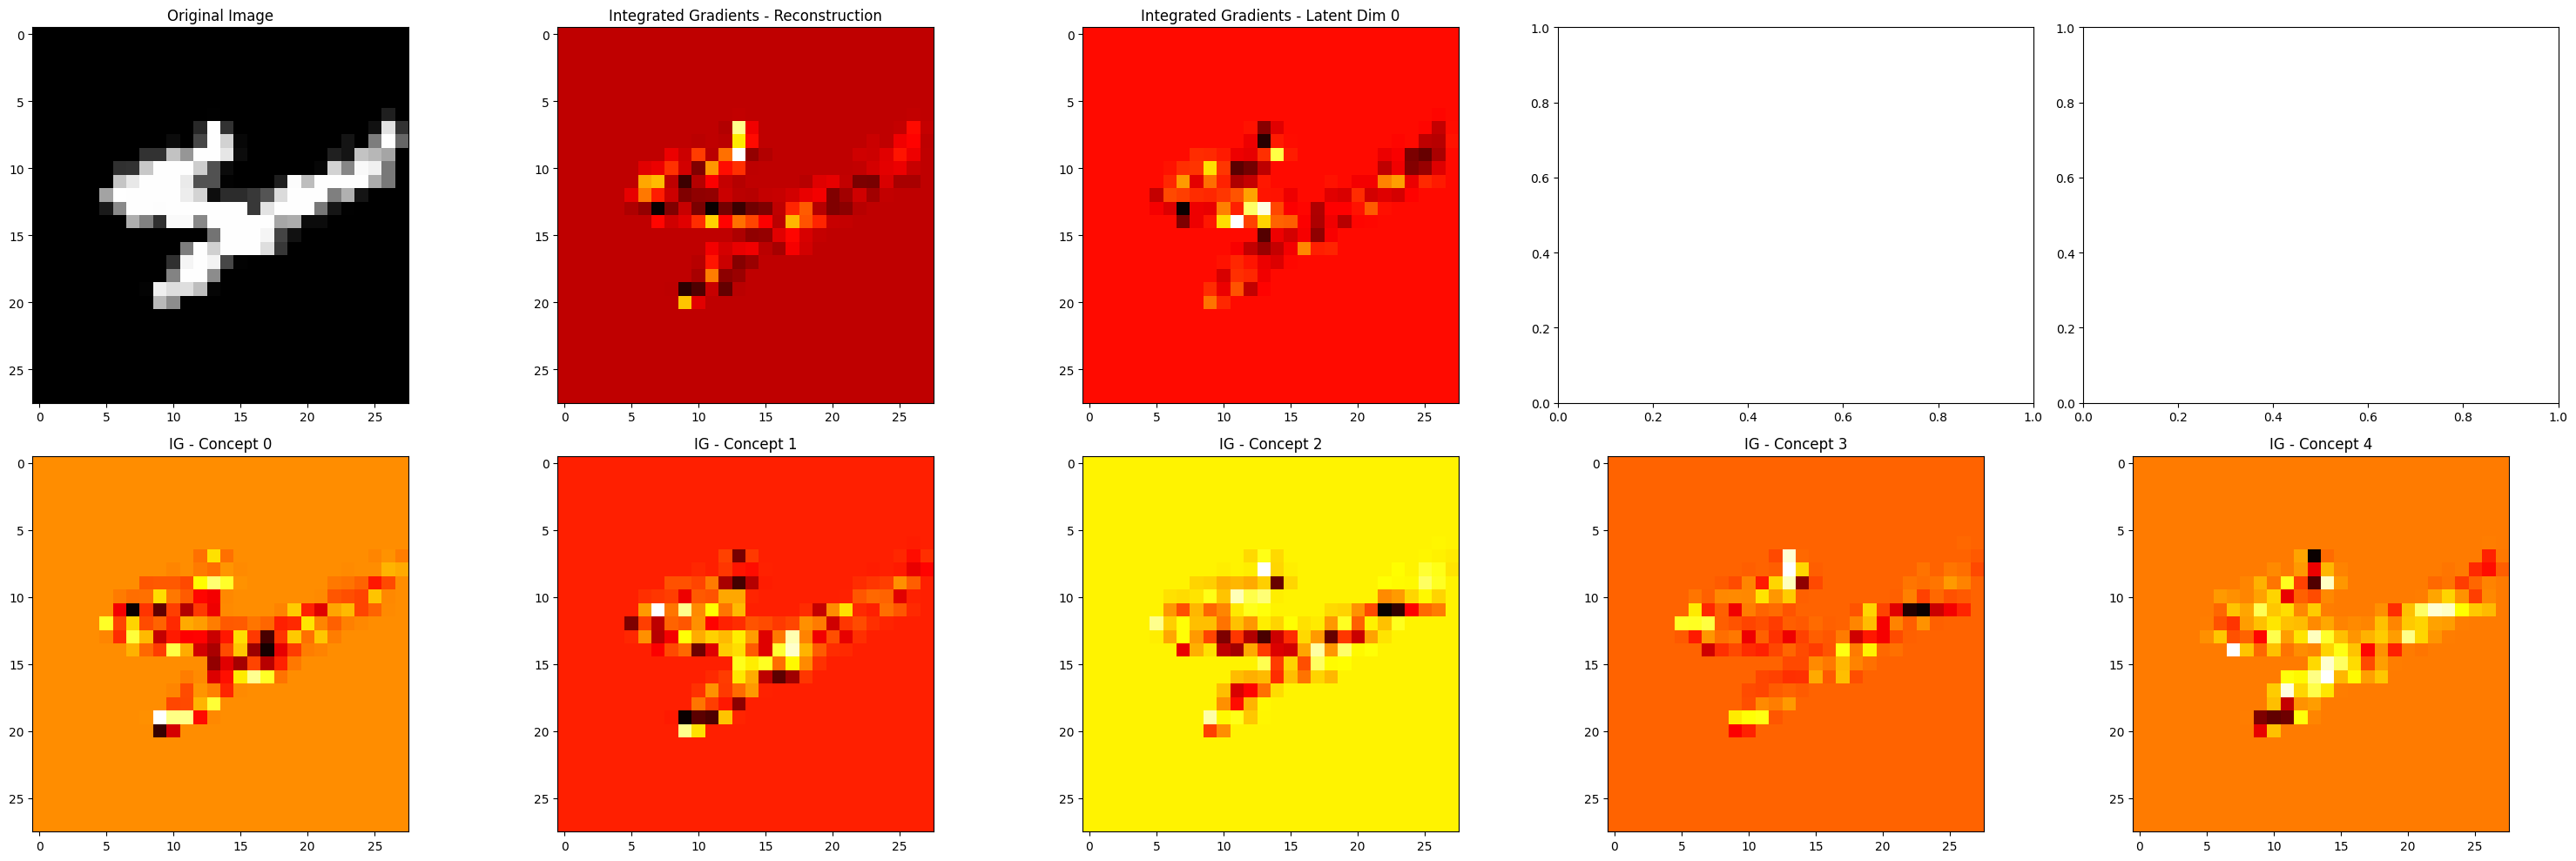

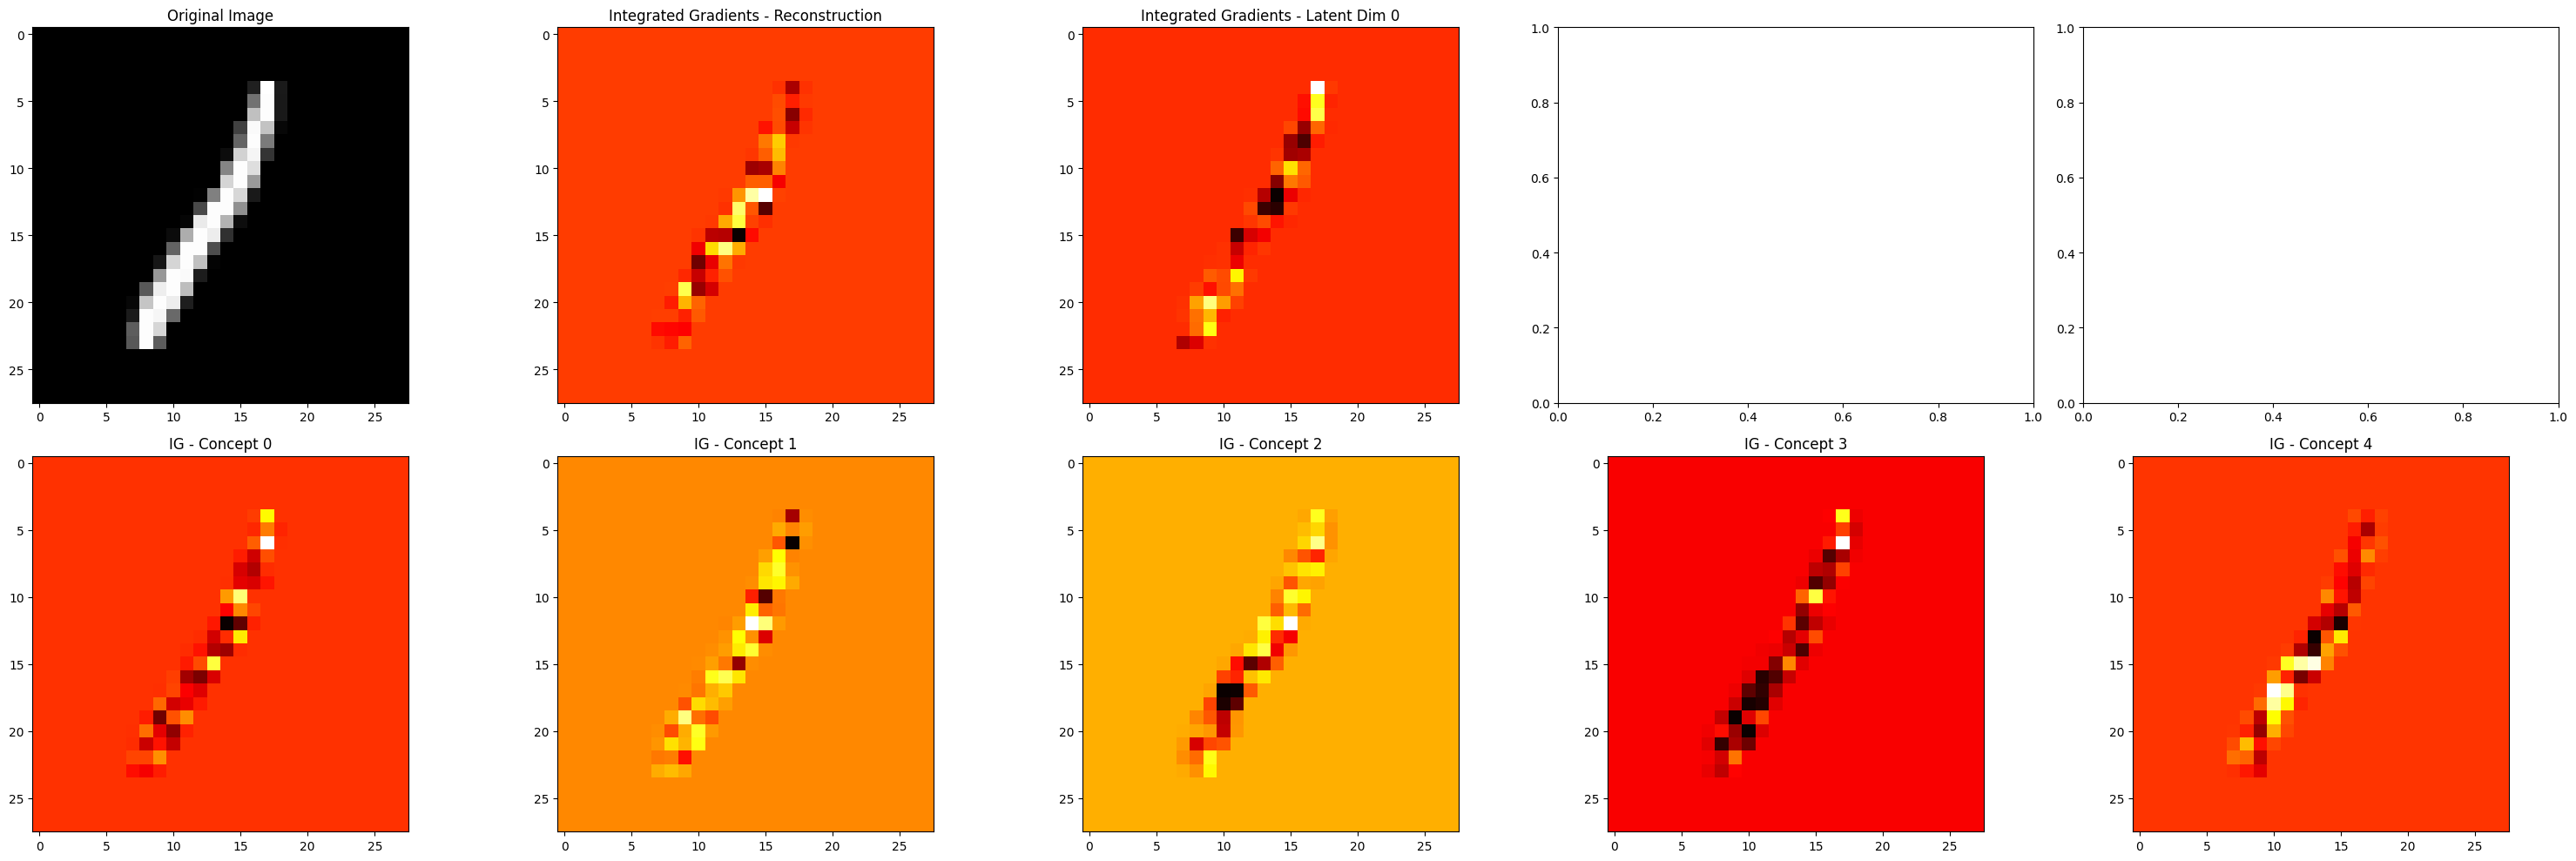

In [94]:
vae_model.to(device)
vae_model.eval()
analyze_with_integrated_gradients(vae_model, val_loader, device, steps=50, num_images=1)

In [91]:
def integrated_gradients_reconstruction(model, input_image, baseline, steps=50):
    model.eval()

    # Scale the inputs along the path
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad_(True)

    # Encode and decode the scaled inputs
    mu, logvar = model.encode(scaled_inputs)
    z = model.reparametrize(mu, logvar)
    reconstructions = model.decode(z)

    # Compute the mean squared error (MSE)
    reconstruction_loss = torch.sum((reconstructions - input_image.repeat(steps + 1, 1, 1, 1))**2, dim=(1, 2, 3))

    # Compute gradients
    grads = grad(outputs=reconstruction_loss, inputs=scaled_inputs,
                 grad_outputs=torch.ones_like(reconstruction_loss),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Integrate
    integrated_grads = (input_image - baseline) * grads.mean(dim=0, keepdim=True)

    return integrated_grads

def integrated_gradients_latent(model, input_image, target_latent_idx, baseline, steps=50):
    """
    Calculates Integrated Gradients with respect to a target latent variable dimension.

    Args:
        model: The VAEIdsia model.
        input_image: The input image tensor (1, C, H, W).
        target_latent_idx: Index of the target latent variable dimension.
        baseline: The baseline image tensor (usually a black image).
        steps: Number of integration steps.

    Returns:
        Integrated Gradients for the input image with respect to the target latent dimension.
    """
    model.eval()

    # Scale the inputs along the path
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad_(True)

    # Encode the scaled inputs
    mu, logvar = model.encode(scaled_inputs)
    z = model.reparametrize(mu, logvar)

    # Target a specific dimension of z
    target_latent = z[:, target_latent_idx]

    # Compute gradients
    grads = grad(outputs=target_latent, inputs=scaled_inputs,
                 grad_outputs=torch.ones_like(target_latent),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Integrate the gradients
    integrated_grads = (input_image - baseline) * grads.mean(dim=0, keepdim=True)

    return integrated_grads

def integrated_gradients_concepts(model, input_image, target_concept_idx, baseline, steps=50):
    """
    Calculates Integrated Gradients with respect to a target concept.

    Args:
        model: The VAEIdsia model.
        input_image: The input image tensor (1, C, H, W).
        target_concept_idx: Index of the target concept in the concept vector.
        baseline: The baseline image tensor (usually a black image).
        steps: Number of integration steps.

    Returns:
        Integrated Gradients for the input image with respect to the target concept.
    """
    model.eval()

    # Scale the inputs along the path
    scaled_inputs = [baseline + (float(i) / steps) * (input_image - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.cat(scaled_inputs, dim=0)
    scaled_inputs.requires_grad_(True)

    # Encode the scaled inputs
    mu, logvar = model.encode(scaled_inputs)
    z = model.reparametrize(mu, logvar)

    # Get the target concept output
    target_concepts = model.concept_bottleneck_layer(z)[:, 0, target_concept_idx]

    # Compute gradients
    grads = grad(outputs=target_concepts, inputs=scaled_inputs,
                 grad_outputs=torch.ones_like(target_concepts),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Integrate the gradients
    integrated_grads = (input_image - baseline) * grads.mean(dim=0, keepdim=True)

    return integrated_grads

def Norm_analyze_with_integrated_gradients(model, image_loader, device, steps=50, num_images=5, num_concepts=5, use_cuda=False):
    """
    Performs Integrated Gradients analysis on a trained VAE model.
    """
    model.eval()

    for batch_idx, (images, labels, _, _) in enumerate(image_loader):
        images = images.to(device)

        for image_idx in range(min(num_images, images.size(0))):
            input_image = images[image_idx].unsqueeze(0)
            baseline_image = torch.zeros_like(input_image).to(device)

            # --- IG with Respect to Reconstruction ---
            ig_reconstruction = integrated_gradients_reconstruction(model, input_image, baseline_image, steps=steps)
            ig_reconstruction_np = ig_reconstruction.squeeze().cpu().detach().numpy()

            # --- IG with Respect to Latent Variable z ---
            target_latent_idx = 0
            ig_latent = integrated_gradients_latent(model, input_image, target_latent_idx, baseline_image, steps=steps)
            ig_latent_np = ig_latent.squeeze().cpu().detach().numpy()

            # --- IG with Respect to Concepts ---
            concept_igs = []
            for target_concept_idx in range(num_concepts):
                ig_concept = integrated_gradients_concepts(model, input_image, target_concept_idx, baseline_image, steps=steps)
                concept_igs.append(ig_concept.squeeze().cpu().detach().numpy())

            # Normalize IG values across all plots for consistent color scale
            max_val_Rec = max(np.max(np.abs(ig_reconstruction_np)), np.max(np.abs(ig_latent_np)),
                          max(np.max(np.abs(ig)) for ig in concept_igs))
            min_val_Rec = -max_val_Rec
            
            max_val_lat = max(np.max(np.abs(ig_latent_np)), max(np.max(np.abs(ig)) for ig in concept_igs))
            min_val_lat = -max_val_lat

            # Visualize
            num_cols = max(3, num_concepts)
            fig, axs = plt.subplots(2, num_cols, figsize=(6 * num_cols, 12))
            
            for i in range(3, num_concepts):
                axs[0, i].axis('off')

            # Original Image
            axs[0, 0].imshow(input_image.squeeze().cpu().detach().numpy(), cmap="gray", interpolation='nearest')
            axs[0, 0].set_title("Original Image", fontsize=14)
            axs[0, 0].axis('off')  # Remove axis ticks and labels

            # IG - Reconstruction
            im = axs[0, 1].imshow(ig_reconstruction_np.squeeze(), cmap="seismic", vmin=min_val_Rec, vmax=max_val_Rec)
            axs[0, 1].set_title("IG - Reconstruction", fontsize=14)
            axs[0, 1].axis('off')
            fig.colorbar(im, ax=axs[0, 1], orientation='horizontal', fraction=0.046, pad=0.04)

            # IG - Latent Variable
            im = axs[0, 2].imshow(ig_latent_np.squeeze(), cmap="seismic", vmin=min_val_lat, vmax=max_val_lat)
            axs[0, 2].set_title(f"IG - Latent Dim {target_latent_idx}", fontsize=14)
            axs[0, 2].axis('off')
            fig.colorbar(im, ax=axs[0, 2], orientation='horizontal', fraction=0.046, pad=0.04)

            # IG - Concepts
            for i, ig_concept_np in enumerate(concept_igs):
                im = axs[1, i].imshow(ig_concept_np.squeeze(), cmap="seismic", vmin=min_val_lat, vmax=max_val_lat)
                axs[1, i].set_title(f"IG - Concept {i}", fontsize=14)
                axs[1, i].axis('off')
                fig.colorbar(im, ax=axs[1, i], orientation='horizontal', fraction=0.046, pad=0.04)

            plt.tight_layout()
            plt.show()

        if batch_idx * images.size(0) >= num_images:
          break

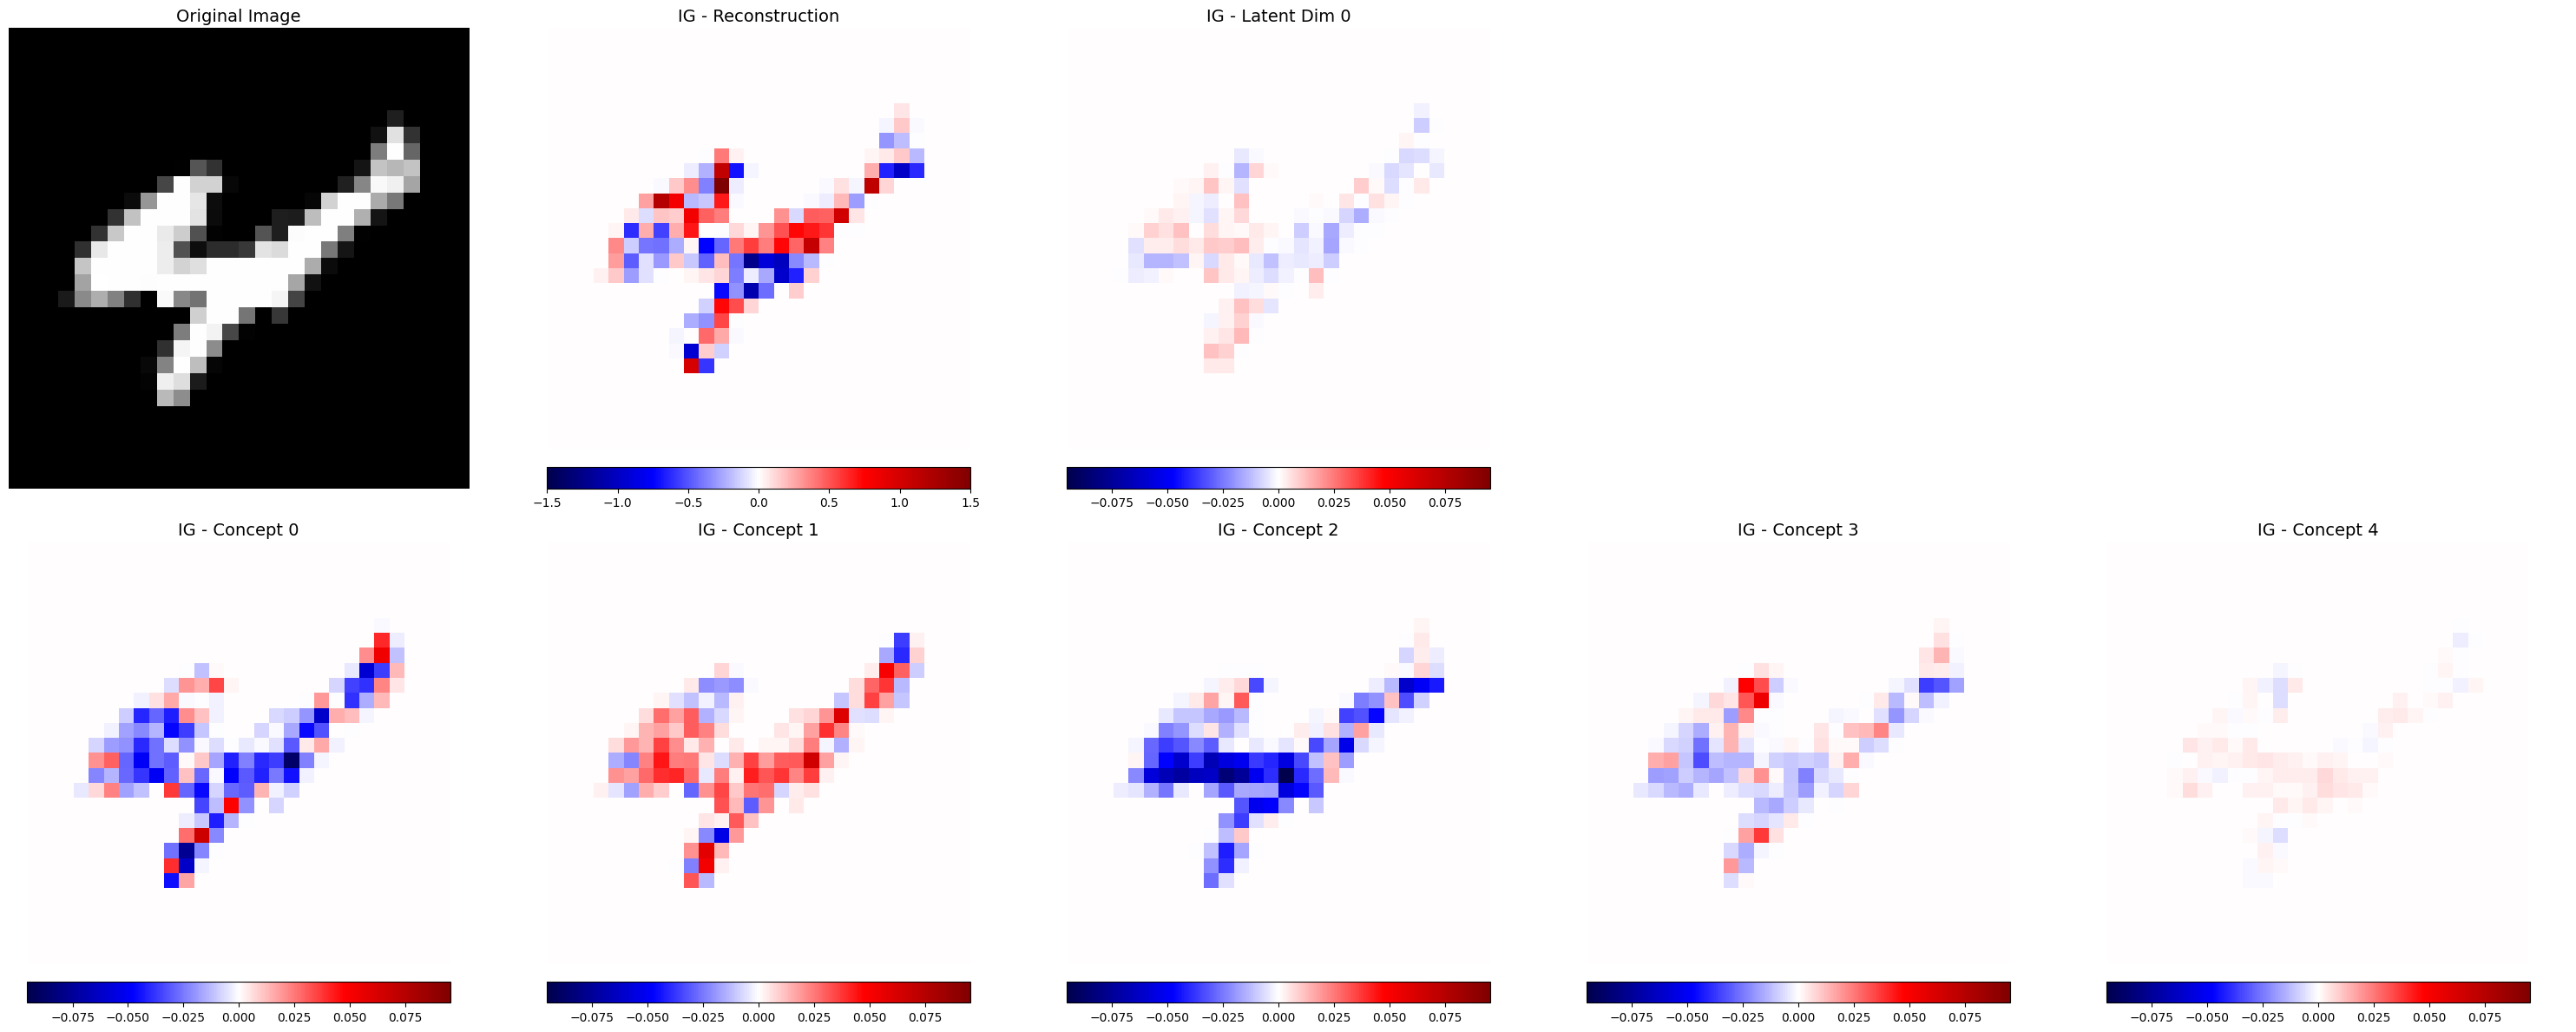

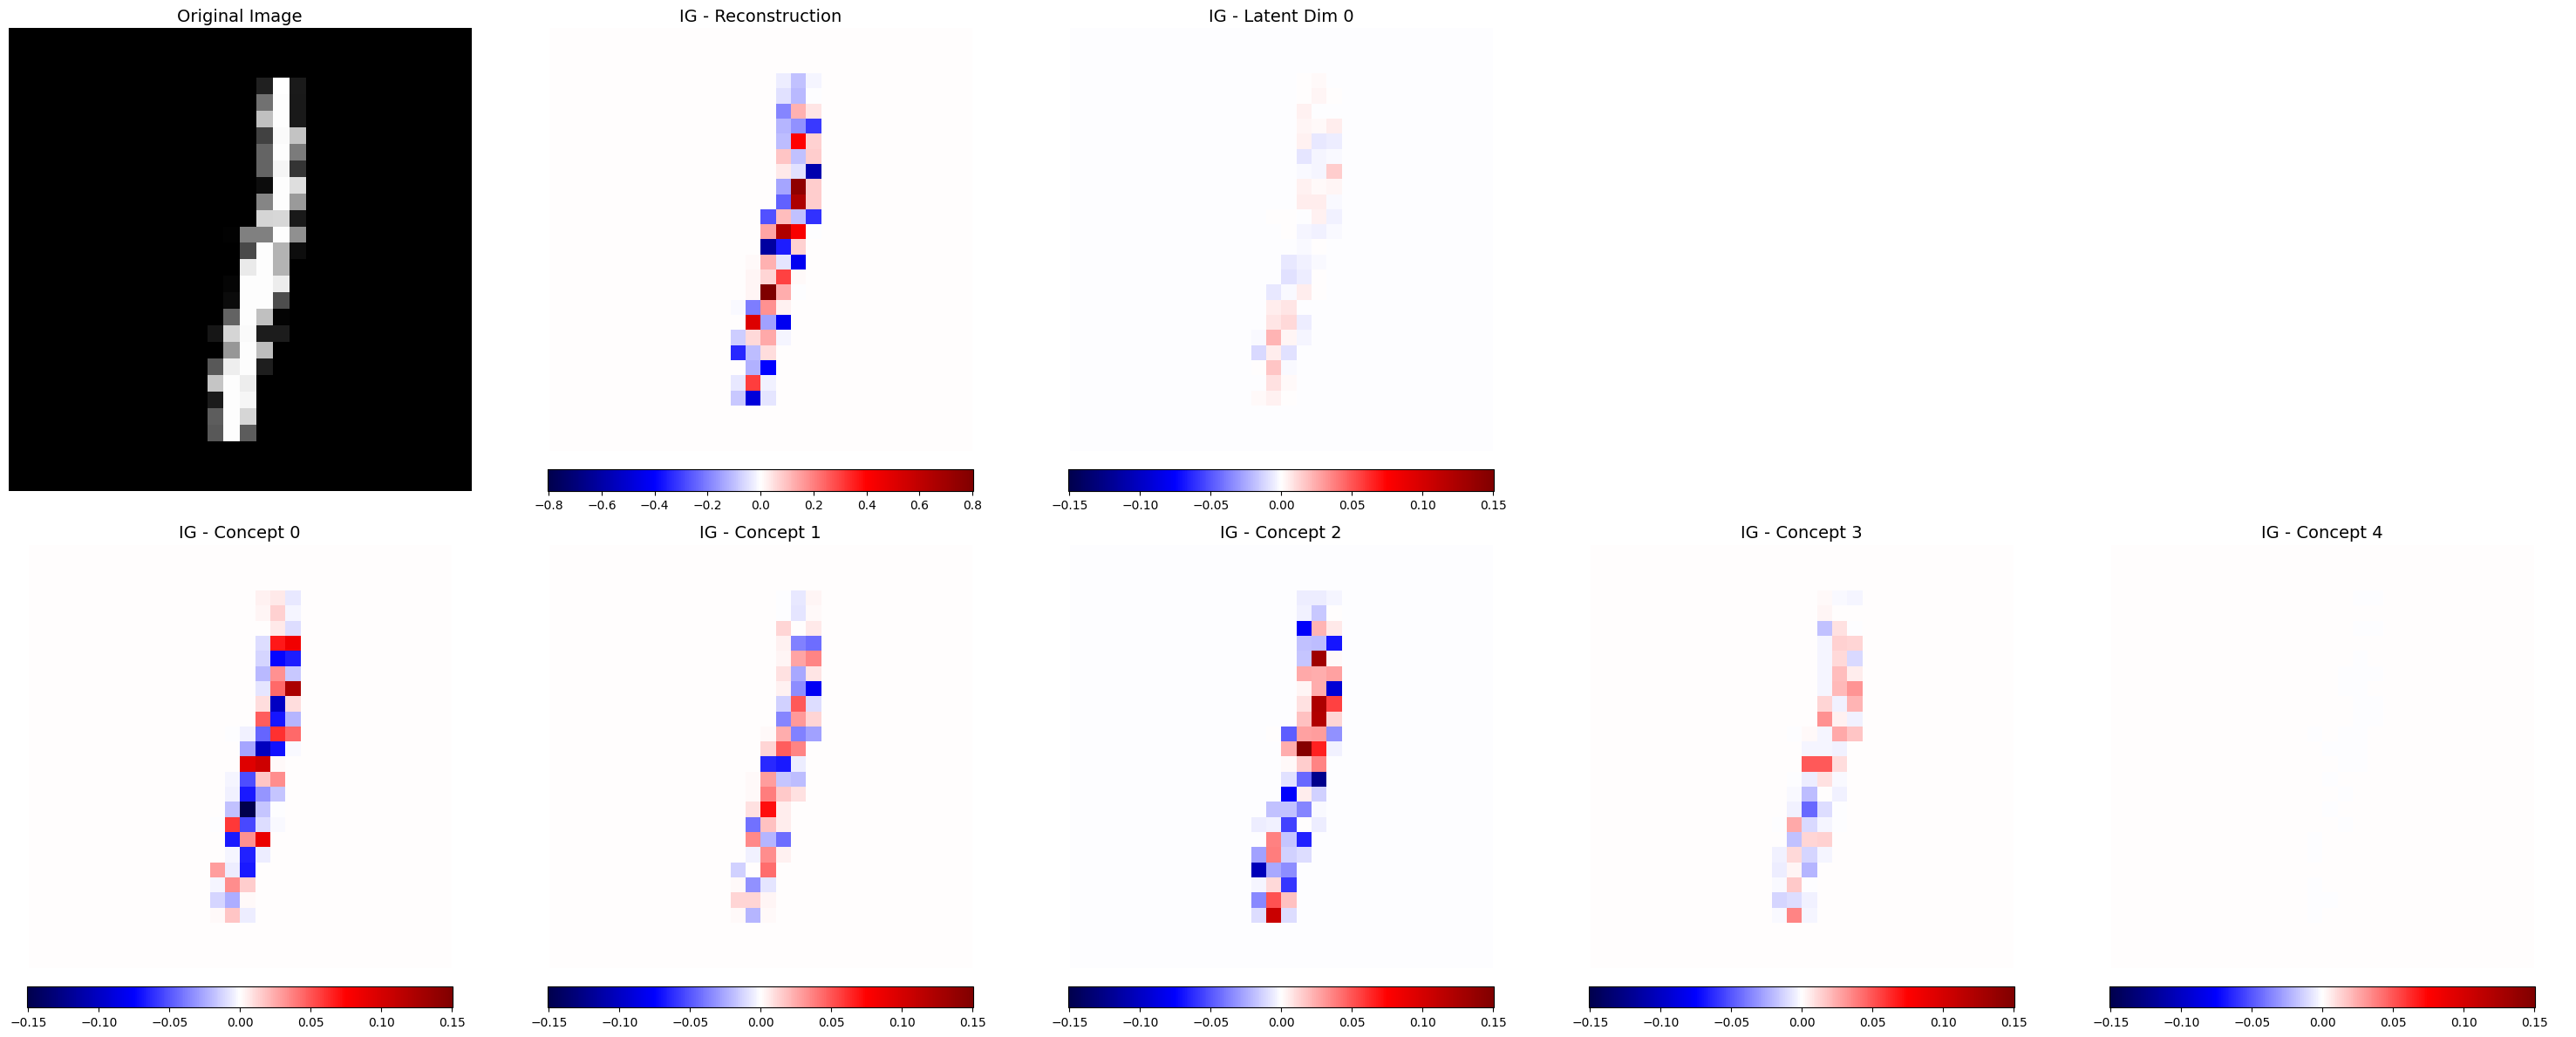

In [92]:
Norm_analyze_with_integrated_gradients(vae_model, val_loader, device, steps=50, num_images=1)